# SIPSA PROJECT
### Developed by [Sébastien Lozano-Forero](https://www.linkedin.com/in/sebastienlozanoforero/)


### Imports

## v1.0 full

Until early september, this version was the most complete dealing with data transformation for both formats. 

### DataCollector

In [3]:
# Set up logging
logger = logging.getLogger('DataCollectorLogger')
logger.setLevel(logging.INFO)

# Create a file handler for logging
file_handler = logging.FileHandler('data_collector.log', mode='w')
file_handler.setLevel(logging.INFO)

# Create a logging format
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)

# Add the file handler to the logger
logger.addHandler(file_handler)

class DataCollector:
    def __init__(self, s3: boto3.resource) -> None:
        """
        Initialize the DataCollector with S3 resource and configuration parameters.
        """
        self.url_base = 'https://www.dane.gov.co'
        self.url = 'https://www.dane.gov.co/index.php/estadisticas-por-tema/agropecuario/sistema-de-informacion-de-precios-sipsa/mayoristas-boletin-semanal-1'
        self.headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36"
        }
        self.s3 = s3
        self.files_tracker_name = 'files_tracker.csv'
        self.logfile_name = 'logfile'

    def all_years_links(self) -> List[str]:
        """
        Get the set of year links available on the DANE webpage.
        """
        response = requests.get(self.url, headers=self.headers)
        soup = BeautifulSoup(response.content, "html.parser")
        link_years = soup.find_all(lambda tag: tag.name == 'a' and re.match(r'^\d+$', tag.get_text().strip()))
        return link_years

    def links_per_year(self, link: str) -> List[str]:
        """
        Get all report links for a specific year.
        """
        r = requests.get(self.url_base + link['href'], headers=self.headers)
        logger.info(f"Working on {link['href'][-4:]} files")
        soup_year = BeautifulSoup(r.content, "html.parser")
        one_year_links = [item for item in soup_year.find_all(target='_blank') if 'Anexo' in item.text]
        return one_year_links

    def check_file_exists_in_s3(self, bucket_name: str, file_name: str) -> bool:
        """
        Check if a file already exists in the S3 bucket.
        """
        try:
            self.s3.Object(bucket_name, file_name).load()
            return True
        except ClientError as e:
            if e.response['Error']['Code'] == '404':
                return False
            else:
                raise

    def load_files_tracker(self, bucket_name: str) -> pd.DataFrame:
        """
        Load the files_tracker.csv from S3 or create a new DataFrame if it does not exist.
        """
        try:
            # Check if files_tracker.csv exists in the bucket
            obj = self.s3.Object(bucket_name, self.files_tracker_name)
            response = obj.get()
            tracker_df = pd.read_csv(BytesIO(response['Body'].read()))
            logger.info("Loaded existing files tracker from S3.")
        except self.s3.meta.client.exceptions.NoSuchKey:
            # If files_tracker.csv does not exist, initialize an empty DataFrame
            tracker_df = pd.DataFrame(columns=['file', 'link', 'date_added'])
            logger.info("No existing files tracker found in S3. Creating a new one.")
        except ClientError as e:
            if e.response['Error']['Code'] == '404':
                tracker_df = pd.DataFrame(columns=['file', 'link', 'date_added'])
                logger.info("No existing files tracker found in S3. Creating a new one.")
            else:
                raise
        return tracker_df

    def update_files_tracker(self, df: pd.DataFrame, bucket_name: str):
        """
        Update the files_tracker.csv in S3.
        """
        buffer = BytesIO()
        df.to_csv(buffer, index=False)
        buffer.seek(0)
        self.s3.Bucket(bucket_name).put_object(Body=buffer, Key=self.files_tracker_name)
        logger.info("Files tracker updated successfully in S3.")

    def upload_or_update_dataframe_to_s3(self, df: pd.DataFrame, bucket_name: str, file_name: str):
        """
        Upload or update a DataFrame as a CSV file to an S3 bucket.
        """
        # Convert DataFrame to CSV in memory
        buffer = BytesIO()
        df.to_csv(buffer, index=False)
        buffer.seek(0)
        self.s3.Bucket(bucket_name).upload_fileobj(buffer, file_name, ExtraArgs={'ContentType': 'text/csv'})
        logger.info(f"DataFrame {file_name} uploaded successfully to S3 bucket {bucket_name}.")

    def download_files_per_year(self, link, bucket_name: str = None):
        """
        Download all files for a specific year and optionally upload them directly to an S3 bucket.

        Args:
            link (str): The link for a specific year.
            bucket_name (str, optional): The name of the S3 bucket to upload the files to. Defaults to None.
        """
        links_per_year = self.links_per_year(link)
        n = len(links_per_year)

        tracker_df = self.load_files_tracker(bucket_name) if bucket_name else None

        new_files_count = 0

        with tqdm(total=n, desc=f"Processing {link['href'][-4:]} files", unit='file') as pbar:
            for i, file in enumerate(links_per_year):
                file_name = f'week_{n - i}_{file["href"].split("/")[-1]}'
                file_link = self.url_base + file['href']

                if bucket_name and file_name in tracker_df['file'].values:
                    pbar.update(1)
                    continue

                try:
                    with requests.get(file_link, headers=self.headers, stream=True) as result:
                        result.raise_for_status()

                        if bucket_name:
                            destination_key = f'reports/{link.text.strip()}/{file_name}'
                            self.s3.Bucket(bucket_name).upload_fileobj(result.raw, destination_key)

                            new_entry = pd.DataFrame({
                                'file': [file_name],
                                'link': [file_link],
                                'date_added': [datetime.datetime.today().strftime('%Y-%m-%d')]
                            })
                            tracker_df = pd.concat([tracker_df, new_entry], ignore_index=True)
                            new_files_count += 1

                except requests.RequestException as e:
                    logger.error(f"Failed to download file from {file['href']}: {e}")
                    continue
                except ClientError as e:
                    logger.error(f"Failed to upload file {file_name} to S3 bucket {bucket_name}: {e}")
                    continue
                finally:
                    pbar.update(1)

        if bucket_name:
            self.update_files_tracker(tracker_df, bucket_name)
            logger.info(f"Year {link['href'][-4:]} processed: {new_files_count} new files uploaded to S3 bucket {bucket_name}.")

    def get_files(self, bucket_name: str = None):
        """
        Download all files from all years and optionally upload them to an S3 bucket.
        """
        all_years_links = self.all_years_links()
        for link in all_years_links:
            self.download_files_per_year(link, bucket_name)

        # Upload log file to S3 after processing
        if bucket_name:
            try:
                self.s3.Bucket(bucket_name).upload_file('data_collector.log', self.logfile_name)
                logger.info(f"Log file {self.logfile_name} uploaded successfully to S3 bucket {bucket_name}.")
            except ClientError as e:
                logger.error(f"Failed to upload log file to S3 bucket {bucket_name}: {e}")

    def display_files_tracker(self, bucket_name: str) -> pd.DataFrame:
        """
        Display the DataFrame contained in the files_tracker.csv file from the S3 bucket.

        Args:
            bucket_name (str): The name of the S3 bucket where files_tracker.csv is stored.

        Returns:
            pd.DataFrame: The contents of files_tracker.csv as a pandas DataFrame.
        """
        try:
            # Check if files_tracker.csv exists in the bucket
            obj = self.s3.Object(bucket_name, self.files_tracker_name)
            response = obj.get()
            tracker_df = pd.read_csv(BytesIO(response['Body'].read()))
            logger.info("Loaded files_tracker.csv from S3 successfully.")
        except self.s3.meta.client.exceptions.NoSuchKey:
            logger.warning("files_tracker.csv does not exist in S3.")
            return pd.DataFrame()  # Return an empty DataFrame if the file does not exist
        except ClientError as e:
            logger.error(f"Failed to load files_tracker.csv from S3: {e}")
            return pd.DataFrame()  # Return an empty DataFrame if there was an error

        # Display the DataFrame
        return tracker_df


### FileNameBuilder

In [4]:
import logging
from pathlib import Path
import boto3

class FileNameBuilder(DataCollector): 
    def __init__(self, s3: boto3.resource): 
        """
        Initialize FileNameBuilder with S3 resource.

        Args:
            s3 (boto3.resource): The boto3 S3 resource to interact with S3.
        """
        super().__init__(s3)

    def first_format_paths(self, bucket_name: str) -> list:
        """
        Get the paths of files in the S3 bucket that match the first format criteria.

        Args:
            bucket_name (str): The name of the S3 bucket.

        Returns:
            list: A list of file paths that match the first format.
        """
        logger.info(f"Fetching first format paths from bucket: {bucket_name}")
        bucket = self.s3.Bucket(bucket_name)
        object_names = [obj.key for obj in bucket.objects.all()]
        
        first_format_years = set(['2012', '2013', '2014', '2015', '2016', '2017', '2018'])
        final_files_paths_first = []

        for path in object_names:
            try:
                year = str(Path(path).parts[1])
                week = int(Path(path).stem.split('_')[1])

                # Check for files in years prior to 2018 and specific weeks in 2018
                if year in first_format_years:
                    if year == '2018' and week > 19:
                        continue
                    final_files_paths_first.append(path)
                    logger.debug(f"File added to first format: {path}")

            except (IndexError, ValueError) as e:
                logger.warning(f"Error processing path {path}: {e}")
        
        logger.info(f"Found {len(final_files_paths_first)} files for the first format.")
        return final_files_paths_first

    def second_format_paths(self, bucket_name: str) -> list:
        """
        Get the paths of files in the S3 bucket that match the second format criteria.

        Args:
            bucket_name (str): The name of the S3 bucket.

        Returns:
            list: A list of file paths that match the second format.
        """
        logger.info(f"Fetching second format paths from bucket: {bucket_name}")
        bucket = self.s3.Bucket(bucket_name)
        object_names = [obj.key for obj in bucket.objects.all()]
        
        second_format_years = set(['2018', '2019', '2020', '2021', '2022', '2023', '2024'])
        final_files_paths_second = []

        for path in object_names:
            try:
                year = str(Path(path).parts[1])
                week = int(Path(path).stem.split('_')[1])

                # Check for files in years after 2018 and specific weeks in 2018
                if year in second_format_years:
                    if year == '2018' and week <= 19:
                        continue
                    final_files_paths_second.append(path)
                    logger.debug(f"File added to second format: {path}")

            except (IndexError, ValueError) as e:
                logger.warning(f"Error processing path {path}: {e}")
        
        logger.info(f"Found {len(final_files_paths_second)} files for the second format.")
        return final_files_paths_second


### DataWrangler

In [7]:
class DataWrangler(FileNameBuilder):
    def __init__(self, 
                 bucket_name:str, 
                 s3: boto3.resource):
        super().__init__(s3)
        self.bucket_name = bucket_name
        self.s3 = s3
        self.categories_dict = categories_dict
        self.city_to_region = city_to_region


    def first_format_data_extraction(self,
                                    file_path:str)-> pd.DataFrame:
        """
        Extracts and processes data from an Excel file stored in an S3 bucket, handling multiple file formats.

        This function attempts to retrieve an Excel file from a specified S3 bucket and process its data.
        It uses two different engines (`openpyxl` and `xlrd`) to read the file, as some files may require 
        different engines depending on their format. If both attempts fail, an error message is logged. 
        It also filters the data to only include rows where the first column contains alphabetic characters 
        (words) and is not empty.

        Args:
            s3 (boto3.resource): A Boto3 resource object used to access the S3 bucket.
            bucket_name (str): The name of the S3 bucket where the file is stored.
            file_path (str): The key (path) of the file within the S3 bucket.

        Returns:
            pd.DataFrame: A pandas DataFrame containing the data from the file. If an error occurs or the 
                          file cannot be read, an empty DataFrame is returned.

        Processing:
        - Retrieves the file from the specified S3 bucket.
        - Attempts to read the file using the `openpyxl` engine for `.xlsx` files first. If that fails, 
          it tries using the `xlrd` engine for `.xls` files.
        - Filters the DataFrame to include only rows where the first column contains alphabetic characters 
          and is not NaN.

        Example Usage:
            first_format_data_extraction(s3, bucket_name, file_path)

        Notes:
            - This function is designed to handle files stored in S3 and may require appropriate AWS 
              credentials to access the S3 bucket.
            - It assumes that the data file is an Excel format (`.xlsx` or `.xls`), and will print a warning 
              if the file cannot be processed.
            - The function does not currently handle other file formats (e.g., `.csv`, `.json`).
        """
        bucket = self.s3.Bucket(self.bucket_name)
        obj = bucket.Object(file_path)

        # Determine file format by extension
    #     file_extension = Path(file_path).suffix.lower()
    #     print(f"Processing file: {file_path}, with extension: {file_extension}")

        # Try to read the file from S3

        xls_data = obj.get()['Body'].read()

        try: 
            dataframe = pd.read_excel(BytesIO(xls_data), engine='openpyxl') 
        except: 
            try:
                dataframe = pd.read_excel(BytesIO(xls_data), engine='xlrd')
            except: 
                print(f'[INFO] {file_path} failed to download')


        if dataframe.shape[0]>0: 
            dataframe = dataframe[dataframe[dataframe.columns[0]].apply(lambda x: bool(re.search(r'[a-zA-Z]', str(x))) and pd.notna(x))]

    # Using a classifier for the extension proved to be a wrong idea as some of the files with one extension would 
    # work with command from another one. 
    #     # Handle .xlsx files with openpyxl engine
    #     if file_extension == '.xlsx':
    #         dataframe = pd.read_excel(BytesIO(xls_data), engine='openpyxl')

    #     # Handle .xls files with xlrd engine
    #     elif file_extension == '.xls':
    #         dataframe = pd.read_excel(BytesIO(xls_data), engine='xlrd')
    #     else:
    #         print(f"Unsupported file extension: {file_path}")
    #         dataframe = pd.DataFrame()  # Handle unsupported file extensions

        return dataframe

    def first_format_data_transformation(self,
                                         dataframe: pd.DataFrame, 
                                         file_path:str) -> pd.DataFrame:
        """
        Transforms the raw data extracted from a file into a structured format with relevant categories and products.

        This function processes the raw data extracted from an Excel file, organizing it into various food categories and
        associated products. The transformation includes:
        - Keeping the first five columns and renaming them.
        - Removing rows where the 'ciudad' column is null.
        - Identifying food categories based on sections of the file marked by the word 'cuadro'.
        - Within each food category, identifying product blocks based on blank values in the 'precio_minimo' column.
        - Adding relevant metadata such as the week number and year from the file path.

        Args:
            dataframe (pd.DataFrame): The raw data extracted from an Excel file.
            file_path (str): The file path or S3 key from which the file was downloaded. Used to extract metadata such as the 
                             year and week number.

        Returns:
            pd.DataFrame: A structured DataFrame with cleaned and organized data. The resulting DataFrame will have the 
                          following columns: 
                          - 'ciudad': The city where the prices were recorded.
                          - 'precio_minimo': The minimum price for the product.
                          - 'precio_maximo': The maximum price for the product.
                          - 'precio_medio': The average price for the product.
                          - 'tendencia': The trend for the product's price.
                          - 'categoria': The food category to which the product belongs (e.g., 'verduras_hortalizas').
                          - 'producto': The specific product being tracked.
                          - 'mercado': The marketplace where the product was sold (if available).
                          - 'semana_no': The week number, extracted from the file name.
                          - 'anho': The year, extracted from the file name.

        Processing Steps:
        - The function first cleans the data by retaining only relevant columns and removing rows with missing cities.
        - It identifies sections of the data marked by the word 'cuadro' and treats them as different food categories.
        - Each category is further broken down into products, where blank values in the 'precio_minimo' column indicate 
          the beginning of a new product block.
        - City and marketplace names are cleaned and standardized.
        - Week number and year information is added based on the file name.

        Example Usage:
            dataframe = pd.read_excel('my_file.xlsx')
            transformed_df = first_format_data_transformation(dataframe, 'data/week_12_2023.xlsx')

        Notes:
            - The function expects that the raw data follows a specific structure with 'cuadro' as a marker for categories and 
              blank 'precio_minimo' values as markers for products within categories.
            - It assumes that the file name contains metadata, specifically the week number and year, in the format 'week_<number>_<year>.xlsx'.
            - The function handles exceptions silently (e.g., missing 'cuadro' titles) and skips problematic parts of the data.
            - 'reports/2015/week_16_Anexo_13_17abr_2015.xls' fails 
        """
        # Keep only the first five columns and rename them
        dataframe = dataframe.iloc[:, 0:5]
        dataframe.columns = ['ciudad', 'precio_minimo', 'precio_maximo', 'precio_medio', 'tendencia']
        dataframe['ciudad'] = dataframe['ciudad'].str.lower().str.replace('bogotá, d.c.', 'bogota')

        # Remove rows where 'ciudad' is null
        dataframe = dataframe[~dataframe['ciudad'].isnull()]

        # This formatting would have eight food categories within the same spreadsheet divided only by a big title.
        # Such title would include the word 'cuadro'. So, to separate categories, we look for blocks of data contained
        # within two consecutive appearances of such words.

        # Get row indexes where the word 'cuadro' is present
        index_cuadro = dataframe[dataframe['ciudad'].str.contains('cuadro')].index

        # Creating target dataframe for all data
        df_final = pd.DataFrame()

        # Iterating over food categories.
        for i_categoria in range(len(index_cuadro) + 1):
            # week 16 of 2015 does not have the 'cuadro' titles. 
            try:
                # Capturing first category
                if i_categoria == 0:
                    dataframe_categoria = dataframe[1:index_cuadro[i_categoria]]
                # capturing intermediate categories
                elif (i_categoria <= 6) and (i_categoria > 0):
                    dataframe_categoria = dataframe[index_cuadro[i_categoria - 1] + 2:index_cuadro[i_categoria]]
                # Capturing last category
                else:
                    dataframe_categoria = dataframe[index_cuadro[i_categoria - 1] + 2:]

                # Within each category block, add category name
                dataframe_categoria['categoria'] = self.categories_dict[i_categoria + 1]

                # within each category block, there are several products. In the whole reporting, products are very likely to
                # contain several rows (same food item in different locations). What identifies such product blocks is the
                # fact that the precio_minimo column will be blank. So the product data would be contain within two
                # consecutive occurrences of blank prices.
                index_producto = dataframe_categoria[dataframe_categoria['precio_minimo'].isnull()].index

                # creating target data frame for product category
                df_categoria_final = pd.DataFrame()

                # Iterating over products within food category
                for i_producto in range(len(index_producto)):

                    # Capturing the first product in the category
                    if i_producto == 0:
                        dataframe_producto = dataframe_categoria.loc[
                                            index_producto[i_producto] - 1:index_producto[i_producto + 1] - 1].reset_index(
                            drop=True)

                    # Capturing all intermediate products
                    elif i_producto < len(index_producto) - 1:
                        dataframe_producto = dataframe_categoria.loc[
                                        index_producto[i_producto]:index_producto[i_producto + 1] - 1].reset_index(
                                drop=True)

                    # Capturing last product within category
                    else:
                        dataframe_producto = dataframe_categoria.loc[index_producto[i_producto]:].reset_index(drop=True)

                    # Adding product name column to each block of products
                    dataframe_producto['producto'] = dataframe_producto['ciudad'][0]

                    # Keeping only city name under the ciudad column
                    dataframe_producto['ciudad'] = dataframe_producto['ciudad'].str.replace(r'\s*\([^)]*\)', '', regex=True)

                    # The name of the marketplaces is included on some of the city names. So we try to retrieve it
                    try:
                        dataframe_producto['mercado'] = dataframe_producto['ciudad'].str.split(',').str[1].str.strip()
                    except:
                        dataframe_producto['mercado'] = np.nan

                    # Getting a clean version of city name
                    try:
                        dataframe_producto['ciudad'] = dataframe_producto['ciudad'].str.split(',').str[0].str.strip()
                    except:
                        None

                    # Dropping first row
                    dataframe_producto = dataframe_producto.drop(0)

                    # Putting together all data for products within food category
                    df_categoria_final = pd.concat([df_categoria_final, dataframe_producto], ignore_index=True)

                # Putting together all data
                df_final = pd.concat([df_final, df_categoria_final], ignore_index=True)
            except: 
                None
            # Once data per file is complete, time stamps are added: year and week number
            df_final['semana_no'] = int(Path(file_path).name.split('_')[1])  # file_path.stem[5:7]
            df_final['anho'] = Path(file_path).stem[-4:]
        try: 
            df_final = df_final[['producto', 'ciudad', 'precio_minimo', 'precio_maximo', 'precio_medio',
           'tendencia', 'categoria', 'mercado', 'semana_no', 'anho']]
        except: 
            print(f'[INFO] {file_path} has no all columns')

        return df_final



    def second_format_data_extraction(self, 
                                      file_path:str) -> pd.DataFrame:
        """
        Extracts and processes data from an Excel file stored in an S3 bucket using multiple sheets for the second format.

        This function retrieves an Excel file from the specified S3 bucket and processes its data, which is spread across
        multiple sheets (typically 8). It handles two possible formats (`openpyxl` for `.xlsx` and `xlrd` for `.xls`), attempting 
        both methods if necessary. The function extracts the relevant data from each sheet, processes it, and returns a combined 
        DataFrame.

        Args:
            s3 (boto3.resource): A Boto3 resource object used to access the S3 bucket.
            bucket_name (str): The name of the S3 bucket where the file is stored.
            file_path (str): The key (path) of the file within the S3 bucket.

        Returns:
            pd.DataFrame: A combined pandas DataFrame with data extracted from all relevant sheets in the Excel file. 
                          The resulting DataFrame will have the following columns:
                          - 'producto': The product being tracked.
                          - 'ciudad': The city where the prices were recorded.
                          - 'precio_minimo': The minimum price for the product.
                          - 'precio_maximo': The maximum price for the product.
                          - 'precio_medio': The average price for the product.
                          - 'tendencia': The trend for the product's price.
                          - 'categoria': The food category of the product.
                          - 'mercado': The marketplace where the product was sold (if available).
                          - 'semana_no': The week number, extracted from the file name.
                          - 'anho': The year, extracted from the file name.

        Processing Steps:
        - The function retrieves the file from S3 using the provided `file_path` and reads the Excel data using both the `openpyxl`
          and `xlrd` engines as necessary.
        - It extracts the names of all the sheets in the file.
        - For each sheet, it processes the data by:
          - Renaming columns to a standardized format.
          - Removing rows with missing city names.
          - Cleaning city and marketplace names.
          - Adding metadata like the product category, week number, and year from the file name.
        - The processed data from all sheets is concatenated into a single DataFrame and returned.

        Example Usage:
            s3 = boto3.resource('s3')
            bucket_name = 'my-bucket'
            file_path = 'data/week_12_2023.xlsx'
            dataframe = second_format_data_extraction(s3, bucket_name, file_path)

        Notes:
            - The function handles both `.xlsx` and `.xls` formats. It will try to read the file with `openpyxl` first, 
              then fall back to `xlrd` if needed.
            - The function assumes that the file has a specific structure, including multiple sheets, and that the 
              sheet names can be used to extract data relevant to food categories.
            - Errors encountered while processing specific files or sheets are logged but not raised, allowing the function 
              to continue processing other files.
        """
        bucket = self.s3.Bucket(self.bucket_name)
        obj = bucket.Object(file_path)
        #  Read the Excel file from S3
        xls_data = obj.get()['Body'].read()

        # Create an ExcelFile object with specified encoding
        try: 
            xl = pd.ExcelFile(BytesIO(xls_data), engine='openpyxl') 
        except: 
            try:
                xl = pd.ExcelFile(BytesIO(xls_data), engine='xlrd')
            except: 
                print(f'[INFO] {file_path} failed to download')
        # Get the list of sheet names
        ref_dic = {i: xl.sheet_names[i] for i in range(len(xl.sheet_names))}


        full_dataframe = pd.DataFrame()
        for index in range(1,9):

            try: 
                dataframe = pd.read_excel(BytesIO(xls_data), engine='openpyxl', sheet_name = ref_dic[index]) 
            except: 
                try:
                    dataframe = pd.read_excel(BytesIO(xls_data), engine='xlrd', sheet_name = ref_dic[index])
                except: 
                    print(f'[INFO] {file_path} failed to download')

            if file_path == 'reports/2018/week_20_Sem_12may__18may_2018.xlsx':
                dataframe['mercado'] = dataframe['Mercado mayorista'].str.split(',').str[1].str.strip()
                dataframe['ciudad'] = dataframe['Mercado mayorista'].str.split(',').str[0].str.strip()
                dataframe.columns = dataframe.columns.str.lower().str.replace(' ','_').str.replace('í','i').str.replace('á','a')
            else:

                if pd.isnull(dataframe.iloc[9, 0]):
                    dataframe = dataframe.iloc[10:, :6]
                else:
                    dataframe = dataframe.iloc[9:, :6]
                dataframe.columns = ['producto', 'ciudad', 'precio_minimo', 'precio_maximo', 'precio_medio', 'tendencia']
            dataframe = dataframe[~dataframe['ciudad'].isnull()]
            dataframe['ciudad'] = dataframe['ciudad'].str.replace(r'\s*\([^)]*\)', '', regex=True)
            dataframe['ciudad'] = dataframe['ciudad'].str.lower().str.replace('bogotá, d.c.', 'bogota')
            dataframe['ciudad'] = dataframe['ciudad'].str.replace(r'\s*\([^)]*\)', '', regex=True)

            # Adding categoria and ciudad info
            dataframe['categoria'] = categories_dict[index]


            # The name of the marketplaces is included on some of the city names. So we try to retrieve it
            try:
                dataframe['mercado'] = dataframe['ciudad'].str.split(',').str[1].str.strip()
            except:
                dataframe['mercado'] = np.nan

            # Getting a clean version of city name
            try:
                dataframe['ciudad'] = dataframe['ciudad'].str.split(',').str[0].str.strip()
            except:
                pass

            # Once data per file is complete, time stamps are added: year and week number
            dataframe['semana_no'] = int(Path(file_path).name.split('_')[1])  # file_path.stem[5:7]
            dataframe['anho'] = Path(file_path).stem[-4:]
            full_dataframe = full_dataframe.append(dataframe)
        full_dataframe = full_dataframe.reset_index(drop = True)

        try: 
            full_dataframe = full_dataframe[['producto', 'ciudad', 'precio_minimo', 'precio_maximo', 'precio_medio',
           'tendencia', 'categoria', 'mercado', 'semana_no', 'anho']]
        except: 
            print(f'[INFO] {file_path} has not all columns')
        return full_dataframe

    def building_complete_report(self):
        """
    Constructs a complete report by extracting and transforming data from two different file formats stored in an S3 bucket.

    This method processes two batches of files from an S3 bucket:
    
    - The first batch is associated with a specific format used for files prior to and including the 19th week of 2018.
    - The second batch is associated with files from after the 19th week of 2018.
    
    For each batch:
    
    1. The method retrieves the file paths for both formats from S3.
    2. For the first format, it extracts the data from each file and applies the required transformations before appending it to a final DataFrame.
    3. For the second format, it extracts the data from each file and appends it to a final DataFrame.
    4. The method finally concatenates both DataFrames (from the two formats) into a single complete report.

    Returns:
        pd.DataFrame: A concatenated DataFrame containing all the data from both file formats, fully extracted and transformed.

    Workflow:
    - Calls `FileNameBuilder.first_format_paths()` to get file paths for the first format.
    - Calls `FileNameBuilder.second_format_paths()` to get file paths for the second format.
    - For each file in the first batch:
        - Uses `first_format_data_extraction()` to extract data from the file.
        - Uses `first_format_data_transformation()` to transform the extracted data.
    - For each file in the second batch:
        - Uses `second_format_data_extraction()` to extract data from the file.
    - Finally, concatenates the processed data from both batches into one DataFrame.

    Args:
        None

    Returns:
        pd.DataFrame: A DataFrame containing all data from both formats processed and concatenated together.

    Example:
        report = self.building_complete_report()
    
    """
        file_names = FileNameBuilder(s3 = self.s3)
        first_format_paths_aws = file_names.first_format_paths(bucket_name = self.bucket_name)
        second_format_paths_aws = file_names.second_format_paths(bucket_name = self.bucket_name)
        first_format_final = pd.DataFrame()
        print('[INFO] First batch of files')
        # print(path_to_file_in_aws)
        for file_path in tqdm(first_format_paths_aws):
            dataframe = self.first_format_data_extraction(file_path = file_path)

            first_format_final = first_format_final.append(
                self.first_format_data_transformation(dataframe = dataframe, 
                                                      file_path = file_path)
            )
        print('[INFO] second batch of files')
        second_format_final = pd.DataFrame()
        for file_path in tqdm(second_format_paths_aws):
            second_format_final = second_format_final.append(self.second_format_data_extraction(file_path = file_path))


        return pd.concat([first_format_final,second_format_final])

## v2.0 development 

### Logging 

In [44]:
%%writefile

import logging
import sys

# Configure logging
def setup_logger():
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.INFO)

    # Create handlers
    c_handler = logging.StreamHandler(sys.stdout)
    f_handler = logging.FileHandler('data_collector.log', mode='w')

    # Set levels
    c_handler.setLevel(logging.INFO)
    f_handler.setLevel(logging.INFO)

    # Create formatters and add them to handlers
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    c_handler.setFormatter(formatter)
    f_handler.setFormatter(formatter)

    # Add handlers to the logger
    logger.addHandler(c_handler)
    logger.addHandler(f_handler)

    return logger

# Initialize logger
logger = setup_logger()


### DataCollector

In [45]:
import boto3
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import datetime
from io import BytesIO
from typing import List
from botocore.exceptions import ClientError
from pathlib import Path
from tqdm import tqdm

class DataCollector:
    def __init__(self, s3: boto3.resource) -> None:
        """
        Initialize the DataCollector with S3 resource and configuration parameters.
        """
        self.url_base = 'https://www.dane.gov.co'
        self.url = 'https://www.dane.gov.co/index.php/estadisticas-por-tema/agropecuario/sistema-de-informacion-de-precios-sipsa/mayoristas-boletin-semanal-1'
        self.headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
        }
        self.s3 = s3
        self.files_tracker_name = 'files_tracker.csv'
        self.logfile_name = 'logfile'

    def all_years_links(self) -> List[BeautifulSoup]:
        """
        Get the set of year links available on the DANE webpage.
        """
        try:
            response = requests.get(self.url, headers=self.headers)
            response.raise_for_status()
        except requests.RequestException as e:
            logger.error(f"Failed to fetch URL {self.url}: {e}")
            return []

        soup = BeautifulSoup(response.content, "html.parser")
        link_years = soup.find_all(lambda tag: tag.name == 'a' and re.match(r'^\d+$', tag.get_text().strip()))
        return link_years

    def links_per_year(self, link: BeautifulSoup) -> List[BeautifulSoup]:
        """
        Get all report links for a specific year.
        """
        try:
            r = requests.get(self.url_base + link['href'], headers=self.headers)
            r.raise_for_status()
        except requests.RequestException as e:
            logger.error(f"Failed to fetch URL {self.url_base + link['href']}: {e}")
            return []

        logger.info(f"Working on {link['href'][-4:]} files")
        soup_year = BeautifulSoup(r.content, "html.parser")
        one_year_links = [item for item in soup_year.find_all(target='_blank') if 'Anexo' in item.text]
        return one_year_links

    def check_file_exists_in_s3(self, bucket_name: str, file_name: str) -> bool:
        """
        Check if a file already exists in the S3 bucket.
        """
        try:
            self.s3.Object(bucket_name, file_name).load()
            return True
        except ClientError as e:
            if e.response['Error']['Code'] == '404':
                return False
            else:
                logger.error(f"ClientError when checking {file_name} in bucket {bucket_name}: {e}")
                raise

    def load_files_tracker(self, bucket_name: str) -> pd.DataFrame:
        """
        Load the files_tracker.csv from S3 or create a new DataFrame if it does not exist.
        """
        try:
            obj = self.s3.Object(bucket_name, self.files_tracker_name)
            response = obj.get()
            tracker_df = pd.read_csv(BytesIO(response['Body'].read()))
            logger.info("Loaded existing files tracker from S3.")
        except self.s3.meta.client.exceptions.NoSuchKey:
            # If files_tracker.csv does not exist, initialize an empty DataFrame
            tracker_df = pd.DataFrame(columns=['file', 'link', 'date_added'])
            logger.info("No existing files tracker found in S3. Creating a new one.")
        except ClientError as e:
            if e.response['Error']['Code'] == 'NoSuchKey':
                tracker_df = pd.DataFrame(columns=['file', 'link', 'date_added'])
                logger.info("No existing files tracker found in S3. Creating a new one.")
            else:
                logger.error(f"ClientError when accessing {self.files_tracker_name}: {e}")
                raise
        return tracker_df

    def update_files_tracker(self, df: pd.DataFrame, bucket_name: str):
        """
        Update the files_tracker.csv in S3.
        """
        buffer = BytesIO()
        df.to_csv(buffer, index=False)
        buffer.seek(0)
        try:
            self.s3.Bucket(bucket_name).put_object(Body=buffer, Key=self.files_tracker_name)
#             logger.info("Files tracker updated successfully in S3.")
        except ClientError as e:
            logger.error(f"Failed to update files tracker in S3 bucket {bucket_name}: {e}")
            raise

    def upload_or_update_dataframe_to_s3(self, df: pd.DataFrame, bucket_name: str, file_name: str):
        """
        Upload or update a DataFrame as a CSV file to an S3 bucket.
        """
        buffer = BytesIO()
        df.to_csv(buffer, index=False)
        buffer.seek(0)
        try:
            self.s3.Bucket(bucket_name).upload_fileobj(buffer, file_name, ExtraArgs={'ContentType': 'text/csv'})
            logger.info(f"DataFrame {file_name} uploaded successfully to S3 bucket {bucket_name}.")
        except ClientError as e:
            logger.error(f"Failed to upload DataFrame {file_name} to S3 bucket {bucket_name}: {e}")
            raise

    def download_files_per_year(self, link: BeautifulSoup, bucket_name: str = None):
        """
        Download all files for a specific year and optionally upload them directly to an S3 bucket.
        """
        links_per_year = self.links_per_year(link)
        n = len(links_per_year)

        tracker_df = self.load_files_tracker(bucket_name) if bucket_name else pd.DataFrame(columns=['file', 'link', 'date_added'])

        new_files_count = 0

        with tqdm(total=n, desc=f"Processing {link['href'][-4:]} files", unit='file') as pbar:
            for i, file in enumerate(links_per_year):
                file_name = f'week_{n - i}_{file["href"].split("/")[-1]}'
                file_link = self.url_base + file['href']

                if bucket_name and file_name in tracker_df['file'].values:
                    pbar.update(1)
                    continue

                try:
                    with requests.get(file_link, headers=self.headers, stream=True) as result:
                        result.raise_for_status()

                        if bucket_name:
                            destination_key = f'reports/{link.text.strip()}/{file_name}'
                            self.s3.Bucket(bucket_name).upload_fileobj(result.raw, destination_key)

                            new_entry = pd.DataFrame({
                                'file': [file_name],
                                'link': [file_link],
                                'date_added': [datetime.datetime.today().strftime('%Y-%m-%d')]
                            })
                            tracker_df = pd.concat([tracker_df, new_entry], ignore_index=True)
                            new_files_count += 1

                except requests.RequestException as e:
                    logger.error(f"Failed to download file from {file_link}: {e}")
                    continue
                except ClientError as e:
                    logger.error(f"Failed to upload file {file_name} to S3 bucket {bucket_name}: {e}")
                    continue
                finally:
                    pbar.update(1)

        if bucket_name:
            self.update_files_tracker(tracker_df, bucket_name)
            logger.info(f"Year {link['href'][-4:]} processed: {new_files_count} new files uploaded to S3 bucket {bucket_name}.")

    def get_files(self, bucket_name: str = None):
        """
        Download all files from all years and optionally upload them to an S3 bucket.
        """
        all_years_links = self.all_years_links()
        for link in all_years_links:
            self.download_files_per_year(link, bucket_name)

        # Upload log file to S3 after processing
        if bucket_name:
            try:
                self.s3.Bucket(bucket_name).upload_file('data_collector.log', self.logfile_name)
                logger.info(f"Log file {self.logfile_name} uploaded successfully to S3 bucket {bucket_name}.")
            except ClientError as e:
                logger.error(f"Failed to upload log file to S3 bucket {bucket_name}: {e}")

    def display_files_tracker(self, bucket_name: str) -> pd.DataFrame:
        """
        Display the DataFrame contained in the files_tracker.csv file from the S3 bucket.
        """
        tracker_df = self.load_files_tracker(bucket_name)
        return tracker_df


### FileNameBuilder

In [47]:
from typing import List

class FileNameBuilder:
    def __init__(self, s3: boto3.resource):
        """
        Initialize FileNameBuilder with S3 resource.
        """
        self.s3 = s3

    def first_format_paths(self, bucket_name: str) -> List[str]:
        """
        Get the paths of files in the S3 bucket that match the first format criteria.
        """
        logger.info(f"Fetching first format paths from bucket: {bucket_name}")
        bucket = self.s3.Bucket(bucket_name)
        object_names = [obj.key for obj in bucket.objects.all() if obj.key.endswith(('.xls', '.xlsx'))]

        first_format_years = {'2012', '2013', '2014', '2015', '2016', '2017'}
        final_files_paths_first = []

        for path in object_names:
            try:
                parts = Path(path).parts
                if len(parts) < 2:
                    continue
                year = parts[1]
                week = int(Path(path).stem.split('_')[1])

                # Check for files in years prior to 2018
                if year in first_format_years:
                    final_files_paths_first.append(path)
                    logger.debug(f"File added to first format: {path}")
                elif year == '2018' and week <= 19:
                    final_files_paths_first.append(path)
                    logger.debug(f"File added to first format: {path}")

            except (IndexError, ValueError) as e:
                logger.warning(f"Error processing path {path}: {e}")

        logger.info(f"Found {len(final_files_paths_first)} files for the first format.")
        return final_files_paths_first

    def second_format_paths(self, bucket_name: str) -> List[str]:
        """
        Get the paths of files in the S3 bucket that match the second format criteria.
        """
        logger.info(f"Fetching second format paths from bucket: {bucket_name}")
        bucket = self.s3.Bucket(bucket_name)
        object_names = [obj.key for obj in bucket.objects.all() if obj.key.endswith(('.xls', '.xlsx'))]

        second_format_years = {'2018', '2019', '2020', '2021', '2022', '2023', '2024'}
        final_files_paths_second = []

        for path in object_names:
            try:
                parts = Path(path).parts
                if len(parts) < 2:
                    continue
                year = parts[1]
                week = int(Path(path).stem.split('_')[1])

                if year in second_format_years:
                    if year == '2018' and week <= 19:
                        continue
                    final_files_paths_second.append(path)
                    logger.debug(f"File added to second format: {path}")

            except (IndexError, ValueError) as e:
                logger.warning(f"Error processing path {path}: {e}")

        logger.info(f"Found {len(final_files_paths_second)} files for the second format.")
        return final_files_paths_second


### DataWrangler

In [159]:
from config import CATEGORIES_DICT, CITY_TO_REGION

class DataWrangler:
    def __init__(self, bucket_name: str, s3: boto3.resource):
        self.bucket_name = bucket_name
        self.s3 = s3
        self.categories_dict = CATEGORIES_DICT
        self.city_to_region = CITY_TO_REGION
        
    def first_format_data_extraction(self, file_path: str) -> pd.DataFrame:
        """
        Extracts and processes data from an Excel file stored in an S3 bucket, handling multiple file formats.
        """
        bucket = self.s3.Bucket(self.bucket_name)
        obj = bucket.Object(file_path)
        xls_data = obj.get()['Body'].read()

        dataframe = None
        try:
            dataframe = pd.read_excel(BytesIO(xls_data), engine='openpyxl')
        except Exception as e:
            logger.debug(f"openpyxl failed for {file_path}: {e}")
        if dataframe is None:
            try:
                dataframe = pd.read_excel(BytesIO(xls_data), engine='xlrd')
            except Exception as e:
                logger.error(f"Failed to read Excel file {file_path} with xlrd: {e}")
                return pd.DataFrame()  # Return empty DataFrame if reading fails

        if dataframe.empty:
            logger.warning(f"No data found in {file_path}")
            return pd.DataFrame()

        dataframe = dataframe[dataframe[dataframe.columns[0]].apply(
            lambda x: bool(re.search(r'[a-zA-Z]', str(x))) and pd.notna(x))]

        return dataframe

    def first_format_data_transformation(self, dataframe: pd.DataFrame, file_path: str) -> pd.DataFrame:
        """
        Transforms the raw data extracted from a file into a structured format with relevant categories and products.
        """
        # Keep only the first five columns and rename them
        dataframe = dataframe.iloc[:, 0:5]
        dataframe.columns = ['ciudad', 'precio_minimo', 'precio_maximo', 'precio_medio', 'tendencia']
        dataframe['ciudad'] = dataframe['ciudad'].str.lower().str.replace('bogotá, d.c.', 'bogota')

        # Remove rows where 'ciudad' is null
        dataframe = dataframe[~dataframe['ciudad'].isnull()]

        # Get row indexes where the word 'cuadro' is present
        index_cuadro = dataframe[dataframe['ciudad'].str.contains('cuadro', case=False, na=False)].index.tolist()

        if not index_cuadro:
            logger.warning(f"No 'cuadro' titles found in {file_path}")
            return pd.DataFrame()  # Return empty DataFrame if no categories found

        # Create target dataframe for all data
        df_final = pd.DataFrame()

        # Iterate over food categories
        for i_categoria in range(len(index_cuadro) + 1):
            try:
                if i_categoria == 0:
                    dataframe_categoria = dataframe.iloc[1:index_cuadro[i_categoria]]
                elif i_categoria <= 6:
                    dataframe_categoria = dataframe.iloc[index_cuadro[i_categoria - 1] + 2:index_cuadro[i_categoria]]
                else:
                    dataframe_categoria = dataframe.iloc[index_cuadro[i_categoria - 1] + 2:]

                # Add category name
                dataframe_categoria = dataframe_categoria.copy()
                dataframe_categoria['categoria'] = self.categories_dict.get(i_categoria + 1, 'unknown')

                # Identify products within category
                index_producto = dataframe_categoria[dataframe_categoria['precio_minimo'].isnull()].index.tolist()
                if not index_producto:
                    continue

                df_categoria_final = pd.DataFrame()

                for i_producto in range(len(index_producto)):
                    if i_producto < len(index_producto) - 1:
                        start_idx = index_producto[i_producto]
                        end_idx = index_producto[i_producto + 1]
                    else:
                        start_idx = index_producto[i_producto]
                        end_idx = None

                    dataframe_producto = dataframe_categoria.loc[start_idx:end_idx].reset_index(drop=True)

                    # Add product name
                    producto_name = dataframe_producto.at[0, 'ciudad']
                    dataframe_producto['producto'] = producto_name

                    # Clean city names
                    dataframe_producto['ciudad'] = dataframe_producto['ciudad'].str.replace(r'\s*\([^)]*\)', '', regex=True)

                    # Extract marketplace if present
                    dataframe_producto['mercado'] = dataframe_producto['ciudad'].str.extract(r',\s*(.*)')[0]
                    dataframe_producto['ciudad'] = dataframe_producto['ciudad'].str.split(',').str[0].str.strip()
                    dataframe_producto = dataframe_producto[~dataframe_producto['precio_medio'].isnull()]
                    
                    # Drop first row (product name)
                    dataframe_producto = dataframe_producto.iloc[1:].reset_index(drop=True)

                    df_categoria_final = pd.concat([df_categoria_final, dataframe_producto], ignore_index=True)

                df_final = pd.concat([df_final, df_categoria_final], ignore_index=True)

            except Exception as e:
                logger.error(f"Error processing category {i_categoria} in file {file_path}: {e}")
                continue

        if df_final.empty:
            logger.warning(f"No data extracted from {file_path} after transformation.")
            return df_final

        # Add timestamps
        try:
            df_final['semana_no'] = int(Path(file_path).stem.split('_')[1])
            df_final['anho'] = Path(file_path).stem[-4:]
        except Exception as e:
            logger.error(f"Error extracting week and year from {file_path}: {e}")
            df_final['semana_no'] = None
            df_final['anho'] = None

        # Reorder columns
        df_final = df_final[['producto', 'ciudad', 'precio_minimo', 'precio_maximo', 'precio_medio',
                             'tendencia', 'categoria', 'mercado', 'semana_no', 'anho']]
        
        df_final= df_final[~df_final['precio_medio'].isnull()]
        
        return df_final

    def second_format_data_extraction(self, file_path: str) -> pd.DataFrame:
        """
        Extracts and processes data from an Excel file stored in an S3 bucket using multiple sheets for the second format.
        """
        bucket = self.s3.Bucket(self.bucket_name)
        obj = bucket.Object(file_path)
        xls_data = obj.get()['Body'].read()

        xl = None
        try:
            xl = pd.ExcelFile(BytesIO(xls_data), engine='openpyxl')
        except Exception as e:
            logger.debug(f"openpyxl failed for {file_path}: {e}")
        if xl is None:
            try:
                xl = pd.ExcelFile(BytesIO(xls_data), engine='xlrd')
            except Exception as e:
                logger.error(f"Failed to read Excel file {file_path} with xlrd: {e}")
                return pd.DataFrame()

        full_dataframe = pd.DataFrame()
        for index in range(1, 9):
            sheet_name = xl.sheet_names[index]
            dataframe = None
            try:
                dataframe = pd.read_excel(BytesIO(xls_data), sheet_name=sheet_name)
            except Exception as e:
                logger.error(f"Failed to read sheet {sheet_name} in {file_path}: {e}")
                continue

            if dataframe.empty:
                logger.warning(f"No data found in sheet {sheet_name} of {file_path}")
                continue

            if file_path == 'reports/2018/week_20_Sem_12may__18may_2018.xlsx':
                dataframe['mercado'] = dataframe['Mercado mayorista'].str.split(',').str[1].str.strip()
                dataframe['ciudad'] = dataframe['Mercado mayorista'].str.split(',').str[0].str.strip()
                dataframe.columns = dataframe.columns.str.lower().str.replace(' ','_').str.replace('í','i').str.replace('á','a')
            else:

                if pd.isnull(dataframe.iloc[9, 0]):
                    dataframe = dataframe.iloc[10:, :6]
                else:
                    dataframe = dataframe.iloc[9:, :6]
                dataframe.columns = ['producto', 'ciudad', 'precio_minimo', 'precio_maximo', 'precio_medio', 'tendencia']
            dataframe = dataframe[~dataframe['ciudad'].isnull()]
            dataframe['ciudad'] = dataframe['ciudad'].str.replace(r'\s*\([^)]*\)', '', regex=True)
            dataframe['ciudad'] = dataframe['ciudad'].str.lower().str.replace('bogotá, d.c.', 'bogota')
            dataframe['ciudad'] = dataframe['ciudad'].str.replace(r'\s*\([^)]*\)', '', regex=True)

            # Adding categoria and ciudad info
            dataframe['categoria'] = self.categories_dict[index]


            # The name of the marketplaces is included on some of the city names. So we try to retrieve it
            try:
                dataframe['mercado'] = dataframe['ciudad'].str.split(',').str[1].str.strip()
            except:
                dataframe['mercado'] = np.nan

            # Getting a clean version of city name
            try:
                dataframe['ciudad'] = dataframe['ciudad'].str.split(',').str[0].str.strip()
            except:
                pass
            # Once data per file is complete, time stamps are added: year and week number
            dataframe['semana_no'] = int(Path(file_path).name.split('_')[1])  # file_path.stem[5:7]
            dataframe['anho'] = Path(file_path).stem[-4:]
          

            # Add to full_dataframe
            full_dataframe = pd.concat([full_dataframe, dataframe], ignore_index=True)

        if full_dataframe.empty:
            logger.warning(f"No data extracted from {file_path} after processing all sheets.")
            return full_dataframe

        # Reorder columns
        full_dataframe = full_dataframe[['producto', 'ciudad', 'precio_minimo', 'precio_maximo', 'precio_medio',
                                         'tendencia', 'categoria', 'mercado', 'semana_no', 'anho']]
        return full_dataframe

    def building_complete_report(self) -> pd.DataFrame:
        """
        Constructs a complete report by extracting and transforming data from two different file formats stored in an S3 bucket.
        """
        file_name_builder = FileNameBuilder(self.s3)
        first_format_paths_aws = file_name_builder.first_format_paths(bucket_name=self.bucket_name)
        second_format_paths_aws = file_name_builder.second_format_paths(bucket_name=self.bucket_name)

        first_format_final = pd.DataFrame()
        logger.info('[INFO] First batch of files')

        for file_path in tqdm(first_format_paths_aws):
            dataframe = self.first_format_data_extraction(file_path)
            if not dataframe.empty:
                transformed_df = self.first_format_data_transformation(dataframe, file_path)
                first_format_final = pd.concat([first_format_final, transformed_df], ignore_index=True)

        logger.info('[INFO] Second batch of files')
        second_format_final = pd.DataFrame()
        for file_path in tqdm(second_format_paths_aws):
            dataframe = self.second_format_data_extraction(file_path)
            second_format_final = pd.concat([second_format_final, dataframe], ignore_index=True)

        complete_report = pd.concat([first_format_final, second_format_final], ignore_index=True)
        return complete_report


### Data Validator

In [99]:

import pandas as pd
import re

class DataValidator:
    def __init__(self):
        # Load or define reference data for validation
        self.valid_cities = [
            'barranquilla', 'bogota', 'bucaramanga', 'cali', 'cartagena', 'cúcuta', 'medellín', 'sincelejo', 
            'valledupar', 'pereira', 'manizales', 'armenia', 'pasto', 'ibagué', 'villavicencio', 'yopal',
            'florencia', 'leticia', 'riohacha', 'neiva', 'montería', 'mocoa', 'puerto carreño', 'mitú', 'inírida',
            'sogamoso', 'tunja', 'pamplona', 'girardot', 'popayán', 'tumaco', 'quibdó', 'villavicencio',
            'arauca', 'buenaventura', 'cartago', 'chiquinquirá', 'la dorada', 'santander'
        ]
        
        self.valid_products = [
            'acelga', 'manzana', 'pollo', 'leche', 'papa', 'arroz', 'frijol', 'tomate', 'cebolla', 'naranja',
            # Add more valid products here
        ]
        
        self.valid_tendencias = ['+', '-', '=', '++', '--', '+++', '---']
        self.valid_categorias = [
            'verduras_hortalizas', 'frutas_frescas', 'tuberculos_raices_platanos', 'granos_cereales',
            'huevos_lacteos', 'carnes', 'pescados', 'productos_procesados'
        ]

    def validate_city(self, city: str) -> bool:
        """Check if the city is valid."""
        return True
#         return city in self.valid_cities

    def validate_product(self, product: str) -> bool:
        """Check if the product is valid."""
        return True
#         return product in self.valid_products


    def validate_price(self, price) -> bool:
        """Check if the price is a positive integer."""
        try:
            return price >= 0
        except TypeError:
            return False

    def validate_tendencia(self, tendencia: str) -> bool:
        """Check if the tendencia is valid."""
        return tendencia in self.valid_tendencias

    def validate_categoria(self, categoria: str) -> bool:
        """Check if the categoria is valid."""
        return categoria in self.valid_categorias
    # Function to remove accents
    
    def remove_accents_trails_caps(self, text):
        return unidecode(text.lower().replace(' ','_'))

    def validate_dataframe(self, dataframe: pd.DataFrame) -> pd.DataFrame:
        """Validate the entire dataframe, and filter out rows that fail validation."""
        try: 
            # Validate each column and store the valid rows in a new DataFrame
            dataframe['ciudad'] = dataframe['ciudad'].apply(self.remove_accents_trails_caps)
            dataframe['producto'] = dataframe['producto'].apply(self.remove_accents_trails_caps)

            valid_df = dataframe[
                dataframe['ciudad'].apply(self.validate_city) &
                dataframe['producto'].apply(self.validate_product) &
                dataframe['precio_minimo'].apply(self.validate_price) &
                dataframe['precio_maximo'].apply(self.validate_price) &
                dataframe['precio_medio'].apply(self.validate_price) &
                dataframe['tendencia'].apply(self.validate_tendencia) &
                dataframe['categoria'].apply(self.validate_categoria)
            ]

            # Log the rows that were removed
            invalid_rows = dataframe[~dataframe.index.isin(valid_df.index)]
    #         if not invalid_rows.empty:
    #             logger.warning(f"Invalid rows found and removed:\n{invalid_rows}")

            return valid_df
        except: 
            dataframe = pd.DataFrame()
            return dataframe

### DataIngestor

In [100]:
table_name = 'product_prices'
text = f"""
CREATE TABLE {table_name} (
    producto VARCHAR(255),
    ciudad VARCHAR(255),
    precio_minimo INT,
    precio_maximo INT,
    precio_medio INT,
    tendencia VARCHAR(10),
    categoria VARCHAR(255),
    mercado VARCHAR(255),
    semana_no INT,
    anho INT
);
"""
print(text)


CREATE TABLE product_prices (
    producto VARCHAR(255),
    ciudad VARCHAR(255),
    precio_minimo INT,
    precio_maximo INT,
    precio_medio INT,
    tendencia VARCHAR(10),
    categoria VARCHAR(255),
    mercado VARCHAR(255),
    semana_no INT,
    anho INT
);



In [101]:
class DataIngestor:
    def __init__(self, 
                 engine:sqlalchemy.engine.base.Engine)-> None:
        self.engine = engine
        
    def insert_dataframe_to_db(self,
                               dataframe: pd.DataFrame, 
                               table_name: str)-> None:
    
        """
        Inserts a DataFrame into a PostgreSQL table.

        :param dataframe: DataFrame to be inserted.
        :param table_name: Name of the PostgreSQL table.
        :param engine: SQLAlchemy engine for the connection.

        """

        try:
            # Insert data in chunks to handle large DataFrames
            dataframe.to_sql(table_name, 
                             self.engine, 
                             if_exists='append', 
                             index=False, 
                             chunksize=500)

            logging.info(f"Data successfully inserted into {table_name}.")
#             print(f"Data successfully inserted into {table_name}.")

        except SQLAlchemyError as e:
            logging.error(f"Error inserting data: {e}")
            print(f"Error inserting data:")

        finally:
            # Close the connection
            engine.dispose()


### ProcessHandler

In [1]:
import boto3
import pandas as pd
from io import BytesIO
from botocore.exceptions import ClientError
from pathlib import Path
import datetime
from tqdm import tqdm
import requests
from bs4 import BeautifulSoup
import re
from typing import List
import logging
from dotenv import load_dotenv
import os
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.exc import SQLAlchemyError
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading credentials
load_dotenv()
aws_access_key_id = os.environ['aws_access_key_id']
aws_secret_access_key = os.environ['aws_secret_access_key']
    
db_user = os.environ['db_user']
db_pass = os.environ['db_pass']
db_host = os.environ['db_host']
db_port = os.environ['db_port']
db_name = os.environ['db_name']

bucket_name = os.environ['bucket_name']


# Creating connection to database
engine = create_engine(f'postgresql://{db_user}:{db_pass}@{db_host}:{db_port}/{db_name}')

# Creating boto3 session (access the S3 bucket)
s3 = boto3.resource('s3',
                    aws_access_key_id = aws_access_key_id, 
                    aws_secret_access_key = aws_secret_access_key)

In [104]:
class ProcessHandler(DataWrangler, DataIngestor, DataCollector):
    def __init__(self, s3, engine, bucket_name, table_name):
        # Initialize DataCollector and other base classes
        DataCollector.__init__(self, s3)
        DataIngestor.__init__(self, engine)
        DataWrangler.__init__(self, bucket_name, s3)

        # Set class attributes
        self.s3 = s3
        self.engine = engine
        self.bucket_name = bucket_name
        self.table_name = table_name

        # Load files tracker after initializing the DataCollector
        self.files_tracker_df = self.load_files_tracker(self.bucket_name)  
        
        # Ensure 'rds_load' column exists in the files_tracker_df
        if 'rds_load' not in self.files_tracker_df.columns:
            self.files_tracker_df['rds_load'] = 'no'
        
        self.data_validator = DataValidator()  # Initialize the DataValidator

    def executing_process(self, output_dataframe: bool = False) -> pd.DataFrame:
        """
        Constructs a complete report by extracting and transforming data from two different file formats stored in an S3 bucket.
        Only processes files not marked as 'rds_load' in the files tracker.
        """
        # Fetch all files from the source
        self.get_files(self.bucket_name)

        # Generate paths for the different file formats
        file_name_builder = FileNameBuilder(self.s3)
        first_format_paths_aws = file_name_builder.first_format_paths(bucket_name=self.bucket_name)
        second_format_paths_aws = file_name_builder.second_format_paths(bucket_name=self.bucket_name)

        first_format_final = pd.DataFrame()
        logger.info('[INFO] First batch of files')

        # Process files in the first format
        for file_path in tqdm(first_format_paths_aws):
            
            file_name = Path(file_path).name
            # Skip files that are already loaded into RDS
            if not self.files_tracker_df.empty and self.files_tracker_df.loc[self.files_tracker_df['file'] == file_name, 'rds_load'].values[0] == 'yes':
                logger.info(f"[INFO] Skipping file {file_name} as it is already loaded into RDS.")
                continue

            dataframe = self.first_format_data_extraction(file_path)
            if not dataframe.empty:
                transformed_df = self.first_format_data_transformation(dataframe, file_path)

                # Validate DataFrame before inserting into the database
                valid_df = self.data_validator.validate_dataframe(transformed_df)

                if output_dataframe:
                    first_format_final = pd.concat([first_format_final, transformed_df], ignore_index=True)
                self.insert_dataframe_to_db(dataframe=valid_df, table_name=self.table_name)
                self.update_files_tracker_with_rds_load(file_name)  # Update tracker after successful load
        logger.info('[INFO] Second batch of files')
        second_format_final = pd.DataFrame()
        
        # Process files in the second format
        for file_path in tqdm(second_format_paths_aws):
            file_name = Path(file_path).name
            # Skip files that are already loaded into RDS
            if not self.files_tracker_df.empty and self.files_tracker_df.loc[self.files_tracker_df['file'] == file_name, 'rds_load'].values[0] == 'yes':
                logger.info(f"[INFO] Skipping file {file_name} as it is already loaded into RDS.")
                continue

            dataframe = self.second_format_data_extraction(file_path)
            
            # Validate DataFrame before inserting into the database
            valid_df = self.data_validator.validate_dataframe(dataframe)
            
            self.insert_dataframe_to_db(dataframe=valid_df, table_name=self.table_name)
            self.update_files_tracker_with_rds_load(file_name)  # Update tracker after successful load
            if output_dataframe:
                second_format_final = pd.concat([second_format_final, dataframe], ignore_index=True)

        if output_dataframe:
            complete_report = pd.concat([first_format_final, second_format_final], ignore_index=True)
            return complete_report


    def update_files_tracker_with_rds_load(self, file_name: str):
        """
        Update the 'rds_load' status in the files tracker after successful insertion into RDS.
        """
        # Check if the file is already present in the tracker and update it
        if file_name in self.files_tracker_df['file'].values:
            self.files_tracker_df.loc[self.files_tracker_df['file'] == file_name, 'rds_load'] = 'yes'
        else:
            # If not present, add a new entry
            new_entry = pd.DataFrame({'file': [file_name], 'rds_load': ['yes']})
            self.files_tracker_df = pd.concat([self.files_tracker_df, new_entry], ignore_index=True)
        
        # Update the tracker in S3
        self.update_files_tracker(self.files_tracker_df, self.bucket_name)

    def querying_db(self, query: str) -> pd.DataFrame:
        """
        Downloads dataframe based on query pulling data from AWS RDS instance.

        Args:
            query (str): SQL query to retrieve data.

        Returns:
            pd.DataFrame with the output of query.
        """
        # Running query and importing it 
        with self.engine.begin() as conn:
            df = pd.read_sql(sql=query, con=conn)

        print(f'[Info] Data Frame with {df.shape[0]} rows and {df.shape[1]} columns imported successfully.')
        return df

## testing playground

In [105]:
import random
from unidecode import unidecode

In [106]:
names = FileNameBuilder(s3 = s3)
first_format = names.first_format_paths(bucket_name = bucket_name)
second_format = names.second_format_paths(bucket_name = bucket_name)

2024-09-28 11:23:27,902 - INFO - Fetching first format paths from bucket: sipsa-bucket
2024-09-28 11:23:27,902 - INFO - Fetching first format paths from bucket: sipsa-bucket


INFO:__main__:Fetching first format paths from bucket: sipsa-bucket


2024-09-28 11:23:28,924 - INFO - Found 285 files for the first format.
2024-09-28 11:23:28,924 - INFO - Found 285 files for the first format.


INFO:__main__:Found 285 files for the first format.


2024-09-28 11:23:28,926 - INFO - Fetching second format paths from bucket: sipsa-bucket
2024-09-28 11:23:28,926 - INFO - Fetching second format paths from bucket: sipsa-bucket


INFO:__main__:Fetching second format paths from bucket: sipsa-bucket


2024-09-28 11:23:29,896 - INFO - Found 333 files for the second format.
2024-09-28 11:23:29,896 - INFO - Found 333 files for the second format.


INFO:__main__:Found 333 files for the second format.


In [107]:
j = random.randint(a = 0, b = len(second_format))
file_path = second_format[j]

In [108]:
testing_validation = DataWrangler(bucket_name = bucket_name, 
                                  s3 = s3 )
validator = DataValidator()

In [113]:
i = random.randint(a = 0, b = len(first_format))
file_path = first_format[i]
# file_path = 'reports/2015/week_16_Anexo_13_17abr_2015.xls'
dataframe = first_format_data_extraction(file_path = file_path)
dataframe = testing_validation.first_format_data_extraction(file_path = file_path)

dataframe = testing_validation.first_format_data_transformation(dataframe = dataframe, 
                                                    file_path = file_path)

dataframe = validator.validate_dataframe(dataframe = dataframe)

dataframe

,producto,ciudad,precio_minimo,precio_maximo,precio_medio,tendencia,categoria,mercado,semana_no,anho
0,acelga,barranquilla,2800,3100,2967,-,verduras_hortalizas,barranquillita,18,2016
1,acelga,bogota,300,700,440,+,verduras_hortalizas,corabastos,18,2016
2,acelga,bucaramanga,1000,1500,1458,+++,verduras_hortalizas,centroabastos,18,2016
3,acelga,cartagena,2100,2100,2100,=,verduras_hortalizas,bazurto,18,2016
4,acelga,chiquinquira,1250,1333,1278,+,verduras_hortalizas,NaN,18,2016
...,...,...,...,...,...,...,...,...,...,...
4259,vinagre,cucuta,1667,1667,1667,=,productos_procesados,la nueva sexta,18,2016
4260,vinagre,pamplona,1500,1583,1563,-,productos_procesados,NaN,18,2016
4261,vinagre,santa_marta,1183,1325,1253,+,productos_procesados,NaN,18,2016
4262,vinagre,sincelejo,2000,2150,2083,=,productos_procesados,NaN,18,2016


In [114]:
i = random.randint(a = 0, b = len(second_format))
file_path = second_format[i]
dataframe = testing_validation.second_format_data_extraction(file_path = file_path)
dataframe = validator.validate_dataframe(dataframe = dataframe)
dataframe

,producto,ciudad,precio_minimo,precio_maximo,precio_medio,tendencia,categoria,mercado,semana_no,anho
0,acelga,armenia,1200,1200,1200,-,verduras_hortalizas,mercar,47,2021
1,acelga,barranquilla,4000,4000,4000,=,verduras_hortalizas,barranquillita,47,2021
2,acelga,bogota,467,667,574,+++,verduras_hortalizas,corabastos,47,2021
3,acelga,bucaramanga,1500,2000,1675,--,verduras_hortalizas,centroabastos,47,2021
4,acelga,chiquinquira,1200,1500,1367,+,verduras_hortalizas,NaN,47,2021
...,...,...,...,...,...,...,...,...,...,...
4440,vinagre,pamplona,1500,1500,1500,=,productos_procesados,NaN,47,2021
4441,vinagre,pereira,4875,5160,4984,=,productos_procesados,mercasa,47,2021
4442,vinagre,santa_marta,1217,1250,1242,=,productos_procesados,NaN,47,2021
4443,vinagre,sincelejo,1125,1333,1229,=,productos_procesados,nuevo mercado,47,2021


## Final testing 

In [118]:
final = ProcessHandler(s3 = s3, 
                       engine = engine, 
                       bucket_name = bucket_name, 
                       table_name = table_name)

2024-09-28 12:29:41,699 - INFO - Loaded existing files tracker from S3.
2024-09-28 12:29:41,699 - INFO - Loaded existing files tracker from S3.


INFO:__main__:Loaded existing files tracker from S3.


In [116]:
df = final.executing_process(output_dataframe = True)

2024-09-28 11:24:11,086 - INFO - Working on 2024 files
2024-09-28 11:24:11,086 - INFO - Working on 2024 files


INFO:__main__:Working on 2024 files


2024-09-28 11:24:11,818 - INFO - Loaded existing files tracker from S3.
2024-09-28 11:24:11,818 - INFO - Loaded existing files tracker from S3.


INFO:__main__:Loaded existing files tracker from S3.
Processing 2024 files: 100%|██████████| 39/39 [00:00<00:00, 9762.93file/s]


2024-09-28 11:24:12,018 - INFO - Year 2024 processed: 0 new files uploaded to S3 bucket sipsa-bucket.
2024-09-28 11:24:12,018 - INFO - Year 2024 processed: 0 new files uploaded to S3 bucket sipsa-bucket.


INFO:__main__:Year 2024 processed: 0 new files uploaded to S3 bucket sipsa-bucket.


2024-09-28 11:24:13,580 - INFO - Working on 2023 files
2024-09-28 11:24:13,580 - INFO - Working on 2023 files


INFO:__main__:Working on 2023 files


2024-09-28 11:24:14,561 - INFO - Loaded existing files tracker from S3.
2024-09-28 11:24:14,561 - INFO - Loaded existing files tracker from S3.


INFO:__main__:Loaded existing files tracker from S3.
Processing 2023 files: 100%|██████████| 54/54 [00:00<00:00, 11276.13file/s]

2024-09-28 11:24:14,722 - INFO - Year 2023 processed: 0 new files uploaded to S3 bucket sipsa-bucket.
2024-09-28 11:24:14,722 - INFO - Year 2023 processed: 0 new files uploaded to S3 bucket sipsa-bucket.



INFO:__main__:Year 2023 processed: 0 new files uploaded to S3 bucket sipsa-bucket.


2024-09-28 11:24:19,212 - INFO - Working on 2022 files
2024-09-28 11:24:19,212 - INFO - Working on 2022 files


INFO:__main__:Working on 2022 files


2024-09-28 11:24:19,506 - INFO - Loaded existing files tracker from S3.
2024-09-28 11:24:19,506 - INFO - Loaded existing files tracker from S3.


INFO:__main__:Loaded existing files tracker from S3.
Processing 2022 files:   0%|          | 0/53 [00:00<?, ?file/s]

2024-09-28 11:24:19,734 - ERROR - Failed to download file from https://www.dane.gov.cohttps://www.dane.gov.co/files/investigaciones/agropecuario/sipsa/anex_22oct_al_28oct_2022.xlsx: HTTPSConnectionPool(host='www.dane.gov.cohttps', port=443): Max retries exceeded with url: //www.dane.gov.co/files/investigaciones/agropecuario/sipsa/anex_22oct_al_28oct_2022.xlsx (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000020B24E3FF10>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
2024-09-28 11:24:19,734 - ERROR - Failed to download file from https://www.dane.gov.cohttps://www.dane.gov.co/files/investigaciones/agropecuario/sipsa/anex_22oct_al_28oct_2022.xlsx: HTTPSConnectionPool(host='www.dane.gov.cohttps', port=443): Max retries exceeded with url: //www.dane.gov.co/files/investigaciones/agropecuario/sipsa/anex_22oct_al_28oct_2022.xlsx (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000020B24E3FF10>: Failed

ERROR:__main__:Failed to download file from https://www.dane.gov.cohttps://www.dane.gov.co/files/investigaciones/agropecuario/sipsa/anex_22oct_al_28oct_2022.xlsx: HTTPSConnectionPool(host='www.dane.gov.cohttps', port=443): Max retries exceeded with url: //www.dane.gov.co/files/investigaciones/agropecuario/sipsa/anex_22oct_al_28oct_2022.xlsx (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000020B24E3FF10>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Processing 2022 files:  21%|██        | 11/53 [00:00<00:00, 48.89file/s]

2024-09-28 11:24:19,748 - ERROR - Failed to download file from https://www.dane.gov.cohttps://www.dane.gov.co/files/investigaciones/agropecuario/sipsa/anex_15oct_al_21oct_2022.xlsx: HTTPSConnectionPool(host='www.dane.gov.cohttps', port=443): Max retries exceeded with url: //www.dane.gov.co/files/investigaciones/agropecuario/sipsa/anex_15oct_al_21oct_2022.xlsx (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000020B24E3F790>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
2024-09-28 11:24:19,748 - ERROR - Failed to download file from https://www.dane.gov.cohttps://www.dane.gov.co/files/investigaciones/agropecuario/sipsa/anex_15oct_al_21oct_2022.xlsx: HTTPSConnectionPool(host='www.dane.gov.cohttps', port=443): Max retries exceeded with url: //www.dane.gov.co/files/investigaciones/agropecuario/sipsa/anex_15oct_al_21oct_2022.xlsx (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000020B24E3F790>: Failed

ERROR:__main__:Failed to download file from https://www.dane.gov.cohttps://www.dane.gov.co/files/investigaciones/agropecuario/sipsa/anex_15oct_al_21oct_2022.xlsx: HTTPSConnectionPool(host='www.dane.gov.cohttps', port=443): Max retries exceeded with url: //www.dane.gov.co/files/investigaciones/agropecuario/sipsa/anex_15oct_al_21oct_2022.xlsx (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000020B24E3F790>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Processing 2022 files: 100%|██████████| 53/53 [00:00<00:00, 217.22file/s]

2024-09-28 11:24:19,927 - INFO - Year 2022 processed: 0 new files uploaded to S3 bucket sipsa-bucket.


2024-09-28 11:24:19,927 - INFO - Year 2022 processed: 0 new files uploaded to S3 bucket sipsa-bucket.


INFO:__main__:Year 2022 processed: 0 new files uploaded to S3 bucket sipsa-bucket.


2024-09-28 11:24:21,717 - INFO - Working on 2021 files
2024-09-28 11:24:21,717 - INFO - Working on 2021 files


INFO:__main__:Working on 2021 files


2024-09-28 11:24:22,254 - INFO - Loaded existing files tracker from S3.
2024-09-28 11:24:22,254 - INFO - Loaded existing files tracker from S3.


INFO:__main__:Loaded existing files tracker from S3.
Processing 2021 files: 100%|██████████| 51/51 [00:00<00:00, 12792.87file/s]

2024-09-28 11:24:22,416 - INFO - Year 2021 processed: 0 new files uploaded to S3 bucket sipsa-bucket.
2024-09-28 11:24:22,416 - INFO - Year 2021 processed: 0 new files uploaded to S3 bucket sipsa-bucket.



INFO:__main__:Year 2021 processed: 0 new files uploaded to S3 bucket sipsa-bucket.


2024-09-28 11:24:23,908 - INFO - Working on 2020 files
2024-09-28 11:24:23,908 - INFO - Working on 2020 files


INFO:__main__:Working on 2020 files


2024-09-28 11:24:24,666 - INFO - Loaded existing files tracker from S3.
2024-09-28 11:24:24,666 - INFO - Loaded existing files tracker from S3.


INFO:__main__:Loaded existing files tracker from S3.
Processing 2020 files: 100%|██████████| 53/53 [00:00<00:00, 7574.30file/s]


2024-09-28 11:24:25,035 - INFO - Year 2020 processed: 0 new files uploaded to S3 bucket sipsa-bucket.
2024-09-28 11:24:25,035 - INFO - Year 2020 processed: 0 new files uploaded to S3 bucket sipsa-bucket.


INFO:__main__:Year 2020 processed: 0 new files uploaded to S3 bucket sipsa-bucket.


2024-09-28 11:24:26,741 - INFO - Working on 2019 files
2024-09-28 11:24:26,741 - INFO - Working on 2019 files


INFO:__main__:Working on 2019 files


2024-09-28 11:24:27,556 - INFO - Loaded existing files tracker from S3.
2024-09-28 11:24:27,556 - INFO - Loaded existing files tracker from S3.


INFO:__main__:Loaded existing files tracker from S3.
Processing 2019 files: 100%|██████████| 52/52 [00:00<00:00, 13008.70file/s]


2024-09-28 11:24:27,887 - INFO - Year 2019 processed: 0 new files uploaded to S3 bucket sipsa-bucket.
2024-09-28 11:24:27,887 - INFO - Year 2019 processed: 0 new files uploaded to S3 bucket sipsa-bucket.


INFO:__main__:Year 2019 processed: 0 new files uploaded to S3 bucket sipsa-bucket.


2024-09-28 11:24:29,490 - INFO - Working on 2018 files
2024-09-28 11:24:29,490 - INFO - Working on 2018 files


INFO:__main__:Working on 2018 files


2024-09-28 11:24:30,516 - INFO - Loaded existing files tracker from S3.
2024-09-28 11:24:30,516 - INFO - Loaded existing files tracker from S3.


INFO:__main__:Loaded existing files tracker from S3.
Processing 2018 files: 100%|██████████| 52/52 [00:00<00:00, 10383.42file/s]


2024-09-28 11:24:30,849 - INFO - Year 2018 processed: 0 new files uploaded to S3 bucket sipsa-bucket.
2024-09-28 11:24:30,849 - INFO - Year 2018 processed: 0 new files uploaded to S3 bucket sipsa-bucket.


INFO:__main__:Year 2018 processed: 0 new files uploaded to S3 bucket sipsa-bucket.


2024-09-28 11:24:32,341 - INFO - Working on 2017 files
2024-09-28 11:24:32,341 - INFO - Working on 2017 files


INFO:__main__:Working on 2017 files


2024-09-28 11:24:32,761 - INFO - Loaded existing files tracker from S3.
2024-09-28 11:24:32,761 - INFO - Loaded existing files tracker from S3.


INFO:__main__:Loaded existing files tracker from S3.
Processing 2017 files: 100%|██████████| 52/52 [00:00<00:00, 5778.20file/s]


2024-09-28 11:24:33,056 - INFO - Year 2017 processed: 0 new files uploaded to S3 bucket sipsa-bucket.
2024-09-28 11:24:33,056 - INFO - Year 2017 processed: 0 new files uploaded to S3 bucket sipsa-bucket.


INFO:__main__:Year 2017 processed: 0 new files uploaded to S3 bucket sipsa-bucket.


2024-09-28 11:24:34,474 - INFO - Working on 2016 files
2024-09-28 11:24:34,474 - INFO - Working on 2016 files


INFO:__main__:Working on 2016 files


2024-09-28 11:24:35,127 - INFO - Loaded existing files tracker from S3.
2024-09-28 11:24:35,127 - INFO - Loaded existing files tracker from S3.


INFO:__main__:Loaded existing files tracker from S3.
Processing 2016 files: 100%|██████████| 52/52 [00:00<00:00, 10446.59file/s]


2024-09-28 11:24:35,407 - INFO - Year 2016 processed: 0 new files uploaded to S3 bucket sipsa-bucket.
2024-09-28 11:24:35,407 - INFO - Year 2016 processed: 0 new files uploaded to S3 bucket sipsa-bucket.


INFO:__main__:Year 2016 processed: 0 new files uploaded to S3 bucket sipsa-bucket.


2024-09-28 11:24:37,457 - INFO - Working on 2015 files
2024-09-28 11:24:37,457 - INFO - Working on 2015 files


INFO:__main__:Working on 2015 files


2024-09-28 11:24:38,241 - INFO - Loaded existing files tracker from S3.
2024-09-28 11:24:38,241 - INFO - Loaded existing files tracker from S3.


INFO:__main__:Loaded existing files tracker from S3.
Processing 2015 files: 100%|██████████| 53/53 [00:00<00:00, 13228.88file/s]

2024-09-28 11:24:38,430 - INFO - Year 2015 processed: 0 new files uploaded to S3 bucket sipsa-bucket.


2024-09-28 11:24:38,430 - INFO - Year 2015 processed: 0 new files uploaded to S3 bucket sipsa-bucket.


INFO:__main__:Year 2015 processed: 0 new files uploaded to S3 bucket sipsa-bucket.


2024-09-28 11:24:39,847 - INFO - Working on 14-1 files
2024-09-28 11:24:39,847 - INFO - Working on 14-1 files


INFO:__main__:Working on 14-1 files


2024-09-28 11:24:40,357 - INFO - Loaded existing files tracker from S3.
2024-09-28 11:24:40,357 - INFO - Loaded existing files tracker from S3.


INFO:__main__:Loaded existing files tracker from S3.
Processing 14-1 files: 100%|██████████| 51/51 [00:00<00:00, 12724.38file/s]


2024-09-28 11:24:40,655 - INFO - Year 14-1 processed: 0 new files uploaded to S3 bucket sipsa-bucket.
2024-09-28 11:24:40,655 - INFO - Year 14-1 processed: 0 new files uploaded to S3 bucket sipsa-bucket.


INFO:__main__:Year 14-1 processed: 0 new files uploaded to S3 bucket sipsa-bucket.


2024-09-28 11:24:42,717 - INFO - Working on 13-1 files
2024-09-28 11:24:42,717 - INFO - Working on 13-1 files


INFO:__main__:Working on 13-1 files


2024-09-28 11:24:43,067 - INFO - Loaded existing files tracker from S3.
2024-09-28 11:24:43,067 - INFO - Loaded existing files tracker from S3.


INFO:__main__:Loaded existing files tracker from S3.
Processing 13-1 files: 100%|██████████| 51/51 [00:00<00:00, 17009.34file/s]

2024-09-28 11:24:43,223 - INFO - Year 13-1 processed: 0 new files uploaded to S3 bucket sipsa-bucket.
2024-09-28 11:24:43,223 - INFO - Year 13-1 processed: 0 new files uploaded to S3 bucket sipsa-bucket.



INFO:__main__:Year 13-1 processed: 0 new files uploaded to S3 bucket sipsa-bucket.


2024-09-28 11:24:44,639 - INFO - Working on 12-1 files
2024-09-28 11:24:44,639 - INFO - Working on 12-1 files


INFO:__main__:Working on 12-1 files


2024-09-28 11:24:44,984 - INFO - Loaded existing files tracker from S3.
2024-09-28 11:24:44,984 - INFO - Loaded existing files tracker from S3.


INFO:__main__:Loaded existing files tracker from S3.
Processing 12-1 files: 100%|██████████| 7/7 [00:00<00:00, 7086.68file/s]

2024-09-28 11:24:45,133 - INFO - Year 12-1 processed: 0 new files uploaded to S3 bucket sipsa-bucket.
2024-09-28 11:24:45,133 - INFO - Year 12-1 processed: 0 new files uploaded to S3 bucket sipsa-bucket.



INFO:__main__:Year 12-1 processed: 0 new files uploaded to S3 bucket sipsa-bucket.


2024-09-28 11:24:45,527 - INFO - Log file logfile uploaded successfully to S3 bucket sipsa-bucket.
2024-09-28 11:24:45,527 - INFO - Log file logfile uploaded successfully to S3 bucket sipsa-bucket.


INFO:__main__:Log file logfile uploaded successfully to S3 bucket sipsa-bucket.


2024-09-28 11:24:45,532 - INFO - Fetching first format paths from bucket: sipsa-bucket
2024-09-28 11:24:45,532 - INFO - Fetching first format paths from bucket: sipsa-bucket


INFO:__main__:Fetching first format paths from bucket: sipsa-bucket


2024-09-28 11:24:46,993 - INFO - Found 285 files for the first format.
2024-09-28 11:24:46,993 - INFO - Found 285 files for the first format.


INFO:__main__:Found 285 files for the first format.


2024-09-28 11:24:47,001 - INFO - Fetching second format paths from bucket: sipsa-bucket
2024-09-28 11:24:47,001 - INFO - Fetching second format paths from bucket: sipsa-bucket


INFO:__main__:Fetching second format paths from bucket: sipsa-bucket


2024-09-28 11:24:47,361 - INFO - Found 333 files for the second format.
2024-09-28 11:24:47,361 - INFO - Found 333 files for the second format.


INFO:__main__:Found 333 files for the second format.


2024-09-28 11:24:47,364 - INFO - [INFO] First batch of files
2024-09-28 11:24:47,364 - INFO - [INFO] First batch of files


INFO:__main__:[INFO] First batch of files
  0%|          | 0/285 [00:00<?, ?it/s]

2024-09-28 11:24:47,374 - INFO - [INFO] Skipping file week_1_Anexo_Bol_Semanal_SIPSA_Noviembre_16_2012.xls as it is already loaded into RDS.
2024-09-28 11:24:47,374 - INFO - [INFO] Skipping file week_1_Anexo_Bol_Semanal_SIPSA_Noviembre_16_2012.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_1_Anexo_Bol_Semanal_SIPSA_Noviembre_16_2012.xls as it is already loaded into RDS.


2024-09-28 11:24:47,380 - INFO - [INFO] Skipping file week_2_Anexo_Bol_Semanal_SIPSA_Noviembre_23_2012.xls as it is already loaded into RDS.
2024-09-28 11:24:47,380 - INFO - [INFO] Skipping file week_2_Anexo_Bol_Semanal_SIPSA_Noviembre_23_2012.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_2_Anexo_Bol_Semanal_SIPSA_Noviembre_23_2012.xls as it is already loaded into RDS.


2024-09-28 11:24:47,384 - INFO - [INFO] Skipping file week_3_Anexo_Bol_Semanal_SIPSA_Noviembre_24_2012.xls as it is already loaded into RDS.
2024-09-28 11:24:47,384 - INFO - [INFO] Skipping file week_3_Anexo_Bol_Semanal_SIPSA_Noviembre_24_2012.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_3_Anexo_Bol_Semanal_SIPSA_Noviembre_24_2012.xls as it is already loaded into RDS.


2024-09-28 11:24:47,392 - INFO - [INFO] Skipping file week_4_Anexo_Bol_Semanal_SIPSA_Diciembre_1_2012.xls as it is already loaded into RDS.
2024-09-28 11:24:47,392 - INFO - [INFO] Skipping file week_4_Anexo_Bol_Semanal_SIPSA_Diciembre_1_2012.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_4_Anexo_Bol_Semanal_SIPSA_Diciembre_1_2012.xls as it is already loaded into RDS.


2024-09-28 11:24:47,419 - INFO - [INFO] Skipping file week_5_Anexo_Bol_Semanal_SIPSA_Diciembre_8_2012.xls as it is already loaded into RDS.
2024-09-28 11:24:47,419 - INFO - [INFO] Skipping file week_5_Anexo_Bol_Semanal_SIPSA_Diciembre_8_2012.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_5_Anexo_Bol_Semanal_SIPSA_Diciembre_8_2012.xls as it is already loaded into RDS.
  2%|▏         | 5/285 [00:00<00:06, 45.87it/s]

2024-09-28 11:24:47,485 - INFO - [INFO] Skipping file week_6_Anexo_Bol_Semanal_SIPSA_Diciembre_15_2012.xls as it is already loaded into RDS.
2024-09-28 11:24:47,485 - INFO - [INFO] Skipping file week_6_Anexo_Bol_Semanal_SIPSA_Diciembre_15_2012.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_6_Anexo_Bol_Semanal_SIPSA_Diciembre_15_2012.xls as it is already loaded into RDS.


2024-09-28 11:24:47,497 - INFO - [INFO] Skipping file week_7_Anexo_Bol_Semanal_SIPSA_Diciembre_28_2012.xls as it is already loaded into RDS.
2024-09-28 11:24:47,497 - INFO - [INFO] Skipping file week_7_Anexo_Bol_Semanal_SIPSA_Diciembre_28_2012.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_7_Anexo_Bol_Semanal_SIPSA_Diciembre_28_2012.xls as it is already loaded into RDS.


2024-09-28 11:24:47,502 - INFO - [INFO] Skipping file week_10_Anexo_Bol_Semanal_SIPSA_marzo2_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:47,502 - INFO - [INFO] Skipping file week_10_Anexo_Bol_Semanal_SIPSA_marzo2_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_10_Anexo_Bol_Semanal_SIPSA_marzo2_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:47,508 - INFO - [INFO] Skipping file week_11_Anexo_Bol_Semanal_SIPSA_marzo9_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:47,508 - INFO - [INFO] Skipping file week_11_Anexo_Bol_Semanal_SIPSA_marzo9_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_11_Anexo_Bol_Semanal_SIPSA_marzo9_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:47,514 - INFO - [INFO] Skipping file week_12_Anexo_Bol_Semanal_SIPSA_marzo16_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:47,514 - INFO - [INFO] Skipping file week_12_Anexo_Bol_Semanal_SIPSA_marzo16_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_12_Anexo_Bol_Semanal_SIPSA_marzo16_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:47,544 - INFO - [INFO] Skipping file week_13_Anexo_Bol_Semanal_SIPSA_marzo23_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:47,544 - INFO - [INFO] Skipping file week_13_Anexo_Bol_Semanal_SIPSA_marzo23_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_13_Anexo_Bol_Semanal_SIPSA_marzo23_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:47,580 - INFO - [INFO] Skipping file week_14_Anexo_Bol_Semanal_SIPSA_abril5_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:47,580 - INFO - [INFO] Skipping file week_14_Anexo_Bol_Semanal_SIPSA_abril5_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_14_Anexo_Bol_Semanal_SIPSA_abril5_2013.xls as it is already loaded into RDS.
  4%|▍         | 12/285 [00:00<00:04, 58.56it/s]

2024-09-28 11:24:47,588 - INFO - [INFO] Skipping file week_15_Anexo_Bol_Semanal_SIPSA_abril6_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:47,588 - INFO - [INFO] Skipping file week_15_Anexo_Bol_Semanal_SIPSA_abril6_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_15_Anexo_Bol_Semanal_SIPSA_abril6_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:47,665 - INFO - [INFO] Skipping file week_16_Anexo_Bol_Semanal_SIPSA_abril20_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:47,665 - INFO - [INFO] Skipping file week_16_Anexo_Bol_Semanal_SIPSA_abril20_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_16_Anexo_Bol_Semanal_SIPSA_abril20_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:47,679 - INFO - [INFO] Skipping file week_17_Anexo_Bol_Semanal_SIPSA_abril27_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:47,679 - INFO - [INFO] Skipping file week_17_Anexo_Bol_Semanal_SIPSA_abril27_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_17_Anexo_Bol_Semanal_SIPSA_abril27_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:47,701 - INFO - [INFO] Skipping file week_18_Anexo_Bol_Semanal_SIPSA_mayo04_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:47,701 - INFO - [INFO] Skipping file week_18_Anexo_Bol_Semanal_SIPSA_mayo04_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_18_Anexo_Bol_Semanal_SIPSA_mayo04_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:47,711 - INFO - [INFO] Skipping file week_19_Anexo_Bol_Semanal_SIPSA_mayo11_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:47,711 - INFO - [INFO] Skipping file week_19_Anexo_Bol_Semanal_SIPSA_mayo11_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_19_Anexo_Bol_Semanal_SIPSA_mayo11_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:47,761 - INFO - [INFO] Skipping file week_1_Anexo_Bol_Semanal_SIPSA_enero_04_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:47,761 - INFO - [INFO] Skipping file week_1_Anexo_Bol_Semanal_SIPSA_enero_04_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_1_Anexo_Bol_Semanal_SIPSA_enero_04_2013.xls as it is already loaded into RDS.
  6%|▋         | 18/285 [00:00<00:07, 36.30it/s]

2024-09-28 11:24:47,829 - INFO - [INFO] Skipping file week_20_Anexo_Bol_Semanal_SIPSA_mayo18_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:47,829 - INFO - [INFO] Skipping file week_20_Anexo_Bol_Semanal_SIPSA_mayo18_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_20_Anexo_Bol_Semanal_SIPSA_mayo18_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:47,834 - INFO - [INFO] Skipping file week_21_Anexo_Bol_Semanal_SIPSA_mayo25_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:47,834 - INFO - [INFO] Skipping file week_21_Anexo_Bol_Semanal_SIPSA_mayo25_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_21_Anexo_Bol_Semanal_SIPSA_mayo25_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:47,848 - INFO - [INFO] Skipping file week_22_Anexo_Bol_Semanal_jun5_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:47,848 - INFO - [INFO] Skipping file week_22_Anexo_Bol_Semanal_jun5_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_22_Anexo_Bol_Semanal_jun5_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:47,875 - INFO - [INFO] Skipping file week_23_Anexo_Bol_Semanal_jun8_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:47,875 - INFO - [INFO] Skipping file week_23_Anexo_Bol_Semanal_jun8_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_23_Anexo_Bol_Semanal_jun8_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:47,880 - INFO - [INFO] Skipping file week_24_Anexo_Bol_Semanal_jun15_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:47,880 - INFO - [INFO] Skipping file week_24_Anexo_Bol_Semanal_jun15_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_24_Anexo_Bol_Semanal_jun15_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:47,885 - INFO - [INFO] Skipping file week_25_Anexo_Bol_Semanal_jun22_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:47,885 - INFO - [INFO] Skipping file week_25_Anexo_Bol_Semanal_jun22_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_25_Anexo_Bol_Semanal_jun22_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:47,913 - INFO - [INFO] Skipping file week_26_Anexo_Bol_Semanal_jun29_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:47,913 - INFO - [INFO] Skipping file week_26_Anexo_Bol_Semanal_jun29_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_26_Anexo_Bol_Semanal_jun29_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:47,919 - INFO - [INFO] Skipping file week_27_Anexo_Bol_Semanal_jul6_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:47,919 - INFO - [INFO] Skipping file week_27_Anexo_Bol_Semanal_jul6_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_27_Anexo_Bol_Semanal_jul6_2013.xls as it is already loaded into RDS.
  9%|▉         | 26/285 [00:00<00:05, 44.06it/s]

2024-09-28 11:24:47,967 - INFO - [INFO] Skipping file week_28_Anexo_Bol_Semanal_jul13_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:47,967 - INFO - [INFO] Skipping file week_28_Anexo_Bol_Semanal_jul13_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_28_Anexo_Bol_Semanal_jul13_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:47,982 - INFO - [INFO] Skipping file week_29_Anexo_Bol_Semanal_jul20_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:47,982 - INFO - [INFO] Skipping file week_29_Anexo_Bol_Semanal_jul20_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_29_Anexo_Bol_Semanal_jul20_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:47,990 - INFO - [INFO] Skipping file week_2_Anexo_Bol_Semanal_SIPSA_enero_11_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:47,990 - INFO - [INFO] Skipping file week_2_Anexo_Bol_Semanal_SIPSA_enero_11_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_2_Anexo_Bol_Semanal_SIPSA_enero_11_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:47,995 - INFO - [INFO] Skipping file week_30_Anexo_Bol_Semanal_jul27_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:47,995 - INFO - [INFO] Skipping file week_30_Anexo_Bol_Semanal_jul27_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_30_Anexo_Bol_Semanal_jul27_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:48,024 - INFO - [INFO] Skipping file week_31_Anexo_Bol_Semanal_ago3_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,024 - INFO - [INFO] Skipping file week_31_Anexo_Bol_Semanal_ago3_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_31_Anexo_Bol_Semanal_ago3_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:48,031 - INFO - [INFO] Skipping file week_32_Anexo_Bol_Semanal_ago10_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,031 - INFO - [INFO] Skipping file week_32_Anexo_Bol_Semanal_ago10_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_32_Anexo_Bol_Semanal_ago10_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:48,038 - INFO - [INFO] Skipping file week_33_Anexo_Bol_Semanal_ago20_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,038 - INFO - [INFO] Skipping file week_33_Anexo_Bol_Semanal_ago20_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_33_Anexo_Bol_Semanal_ago20_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:48,051 - INFO - [INFO] Skipping file week_34_Anexo_Bol_Semanal_ago30_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,051 - INFO - [INFO] Skipping file week_34_Anexo_Bol_Semanal_ago30_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_34_Anexo_Bol_Semanal_ago30_2013.xls as it is already loaded into RDS.
 12%|█▏        | 34/285 [00:00<00:04, 51.83it/s]

2024-09-28 11:24:48,078 - INFO - [INFO] Skipping file week_35_Anexo_Bol_Semanal_sept6_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,078 - INFO - [INFO] Skipping file week_35_Anexo_Bol_Semanal_sept6_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_35_Anexo_Bol_Semanal_sept6_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:48,088 - INFO - [INFO] Skipping file week_36_Anexo_Bol_Semanal_sept7_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,088 - INFO - [INFO] Skipping file week_36_Anexo_Bol_Semanal_sept7_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_36_Anexo_Bol_Semanal_sept7_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:48,101 - INFO - [INFO] Skipping file week_37_Anexo_Bol_Semanal_sept14_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,101 - INFO - [INFO] Skipping file week_37_Anexo_Bol_Semanal_sept14_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_37_Anexo_Bol_Semanal_sept14_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:48,107 - INFO - [INFO] Skipping file week_38_Anexo_Bol_Semanal_sept23_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,107 - INFO - [INFO] Skipping file week_38_Anexo_Bol_Semanal_sept23_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_38_Anexo_Bol_Semanal_sept23_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:48,112 - INFO - [INFO] Skipping file week_39_Anexo_Bol_Semanal_oct4_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,112 - INFO - [INFO] Skipping file week_39_Anexo_Bol_Semanal_oct4_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_39_Anexo_Bol_Semanal_oct4_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:48,117 - INFO - [INFO] Skipping file week_3_Anexo_Bol_Semanal_SIPSA_enero_12_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,117 - INFO - [INFO] Skipping file week_3_Anexo_Bol_Semanal_SIPSA_enero_12_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_3_Anexo_Bol_Semanal_SIPSA_enero_12_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:48,123 - INFO - [INFO] Skipping file week_40_Anexo_Bol_Semanal_oct5_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,123 - INFO - [INFO] Skipping file week_40_Anexo_Bol_Semanal_oct5_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_40_Anexo_Bol_Semanal_oct5_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:48,149 - INFO - [INFO] Skipping file week_41_Anexo_Bol_Semanal_oct12_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,149 - INFO - [INFO] Skipping file week_41_Anexo_Bol_Semanal_oct12_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_41_Anexo_Bol_Semanal_oct12_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:48,165 - INFO - [INFO] Skipping file week_42_Anexo_Bol_Semanal_oct19_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,165 - INFO - [INFO] Skipping file week_42_Anexo_Bol_Semanal_oct19_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_42_Anexo_Bol_Semanal_oct19_2013.xls as it is already loaded into RDS.
 15%|█▌        | 43/285 [00:00<00:03, 61.27it/s]

2024-09-28 11:24:48,185 - INFO - [INFO] Skipping file week_43_Anexo_Bol_Semanal_oct26_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,185 - INFO - [INFO] Skipping file week_43_Anexo_Bol_Semanal_oct26_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_43_Anexo_Bol_Semanal_oct26_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:48,215 - INFO - [INFO] Skipping file week_44_Anexo_Bol_Semanal_nov2_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,215 - INFO - [INFO] Skipping file week_44_Anexo_Bol_Semanal_nov2_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_44_Anexo_Bol_Semanal_nov2_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:48,222 - INFO - [INFO] Skipping file week_45_Anexo_Bol_Semanal_nov9_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,222 - INFO - [INFO] Skipping file week_45_Anexo_Bol_Semanal_nov9_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_45_Anexo_Bol_Semanal_nov9_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:48,233 - INFO - [INFO] Skipping file week_46_Anexo_Bol_Semanal_nov16_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,233 - INFO - [INFO] Skipping file week_46_Anexo_Bol_Semanal_nov16_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_46_Anexo_Bol_Semanal_nov16_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:48,241 - INFO - [INFO] Skipping file week_47_Anexo_Bol_Semanal_nov23_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,241 - INFO - [INFO] Skipping file week_47_Anexo_Bol_Semanal_nov23_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_47_Anexo_Bol_Semanal_nov23_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:48,267 - INFO - [INFO] Skipping file week_48_Anexo_Bol_Semanal_nov29_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,267 - INFO - [INFO] Skipping file week_48_Anexo_Bol_Semanal_nov29_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_48_Anexo_Bol_Semanal_nov29_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:48,281 - INFO - [INFO] Skipping file week_49_Anexo_Bol_Semanal_dic13_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,281 - INFO - [INFO] Skipping file week_49_Anexo_Bol_Semanal_dic13_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_49_Anexo_Bol_Semanal_dic13_2013.xls as it is already loaded into RDS.
 18%|█▊        | 50/285 [00:00<00:03, 62.98it/s]

2024-09-28 11:24:48,288 - INFO - [INFO] Skipping file week_4_Anexo_Bol_Semanal_SIPSA_enero_19_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,288 - INFO - [INFO] Skipping file week_4_Anexo_Bol_Semanal_SIPSA_enero_19_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_4_Anexo_Bol_Semanal_SIPSA_enero_19_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:48,293 - INFO - [INFO] Skipping file week_50_Anexo_Bol_Semanal_dic14_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,293 - INFO - [INFO] Skipping file week_50_Anexo_Bol_Semanal_dic14_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_50_Anexo_Bol_Semanal_dic14_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:48,309 - INFO - [INFO] Skipping file week_51_Anexo_Bol_Semanal_dic21_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,309 - INFO - [INFO] Skipping file week_51_Anexo_Bol_Semanal_dic21_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_51_Anexo_Bol_Semanal_dic21_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:48,328 - INFO - [INFO] Skipping file week_5_Anexo_Bol_Semanal_SIPSA_enero_26_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,328 - INFO - [INFO] Skipping file week_5_Anexo_Bol_Semanal_SIPSA_enero_26_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_5_Anexo_Bol_Semanal_SIPSA_enero_26_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:48,334 - INFO - [INFO] Skipping file week_6_Anexo_Bol_Semanal_SIPSA_febrero_2_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,334 - INFO - [INFO] Skipping file week_6_Anexo_Bol_Semanal_SIPSA_febrero_2_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_6_Anexo_Bol_Semanal_SIPSA_febrero_2_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:48,344 - INFO - [INFO] Skipping file week_7_Anexo_Bol_Semanal_SIPSA_febrero_9_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,344 - INFO - [INFO] Skipping file week_7_Anexo_Bol_Semanal_SIPSA_febrero_9_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_7_Anexo_Bol_Semanal_SIPSA_febrero_9_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:48,350 - INFO - [INFO] Skipping file week_8_Anexo_Bol_Semanal_SIPSA_febrero_16_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,350 - INFO - [INFO] Skipping file week_8_Anexo_Bol_Semanal_SIPSA_febrero_16_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_8_Anexo_Bol_Semanal_SIPSA_febrero_16_2013.xls as it is already loaded into RDS.


2024-09-28 11:24:48,357 - INFO - [INFO] Skipping file week_9_Anexo_Bol_Semanal_SIPSA_febrero_23_2013.xls as it is already loaded into RDS.
2024-09-28 11:24:48,357 - INFO - [INFO] Skipping file week_9_Anexo_Bol_Semanal_SIPSA_febrero_23_2013.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_9_Anexo_Bol_Semanal_SIPSA_febrero_23_2013.xls as it is already loaded into RDS.
 20%|██        | 58/285 [00:01<00:03, 66.62it/s]

2024-09-28 11:24:48,398 - INFO - [INFO] Skipping file week_10_Anexo_Bol_Semanal_mar1_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,398 - INFO - [INFO] Skipping file week_10_Anexo_Bol_Semanal_mar1_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_10_Anexo_Bol_Semanal_mar1_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,403 - INFO - [INFO] Skipping file week_11_Anexo_Bol_Semanal_mar8_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,403 - INFO - [INFO] Skipping file week_11_Anexo_Bol_Semanal_mar8_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_11_Anexo_Bol_Semanal_mar8_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,410 - INFO - [INFO] Skipping file week_12_Anexo_Bol_Semanal_mar15_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,410 - INFO - [INFO] Skipping file week_12_Anexo_Bol_Semanal_mar15_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_12_Anexo_Bol_Semanal_mar15_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,415 - INFO - [INFO] Skipping file week_13_Anexo_Bol_Semanal_mar22_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,415 - INFO - [INFO] Skipping file week_13_Anexo_Bol_Semanal_mar22_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_13_Anexo_Bol_Semanal_mar22_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,447 - INFO - [INFO] Skipping file week_14_Anexo_Bol_Semanal_mar29_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,447 - INFO - [INFO] Skipping file week_14_Anexo_Bol_Semanal_mar29_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_14_Anexo_Bol_Semanal_mar29_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,466 - INFO - [INFO] Skipping file week_15_Anexo_Bol_Semanal_abr5_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,466 - INFO - [INFO] Skipping file week_15_Anexo_Bol_Semanal_abr5_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_15_Anexo_Bol_Semanal_abr5_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,472 - INFO - [INFO] Skipping file week_16_Anexo_Bol_Semanal_abr16_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,472 - INFO - [INFO] Skipping file week_16_Anexo_Bol_Semanal_abr16_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_16_Anexo_Bol_Semanal_abr16_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,478 - INFO - [INFO] Skipping file week_17_Anexo_Bol_Semanal_abr19_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,478 - INFO - [INFO] Skipping file week_17_Anexo_Bol_Semanal_abr19_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_17_Anexo_Bol_Semanal_abr19_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,482 - INFO - [INFO] Skipping file week_18_Anexo_Bol_Semanal_may2_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,482 - INFO - [INFO] Skipping file week_18_Anexo_Bol_Semanal_may2_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_18_Anexo_Bol_Semanal_may2_2014.xls as it is already loaded into RDS.
 24%|██▎       | 67/285 [00:01<00:03, 69.41it/s]

2024-09-28 11:24:48,512 - INFO - [INFO] Skipping file week_19_Anexo_Bol_Semanal_may3_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,512 - INFO - [INFO] Skipping file week_19_Anexo_Bol_Semanal_may3_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_19_Anexo_Bol_Semanal_may3_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,518 - INFO - [INFO] Skipping file week_1_Anexo_Bol_Semanal_ene3_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,518 - INFO - [INFO] Skipping file week_1_Anexo_Bol_Semanal_ene3_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_1_Anexo_Bol_Semanal_ene3_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,531 - INFO - [INFO] Skipping file week_20_Anexo_Bol_Semanal_100may10_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,531 - INFO - [INFO] Skipping file week_20_Anexo_Bol_Semanal_100may10_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_20_Anexo_Bol_Semanal_100may10_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,541 - INFO - [INFO] Skipping file week_21_Anexo_Bol_Semanal_may17_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,541 - INFO - [INFO] Skipping file week_21_Anexo_Bol_Semanal_may17_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_21_Anexo_Bol_Semanal_may17_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,567 - INFO - [INFO] Skipping file week_22_Anexo_Bol_Semanal_may24_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,567 - INFO - [INFO] Skipping file week_22_Anexo_Bol_Semanal_may24_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_22_Anexo_Bol_Semanal_may24_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,577 - INFO - [INFO] Skipping file week_23_Anexo_Bol_Semanal_jun6_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,577 - INFO - [INFO] Skipping file week_23_Anexo_Bol_Semanal_jun6_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_23_Anexo_Bol_Semanal_jun6_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,583 - INFO - [INFO] Skipping file week_24_Anexo_Bol_Semanal_jun7_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,583 - INFO - [INFO] Skipping file week_24_Anexo_Bol_Semanal_jun7_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_24_Anexo_Bol_Semanal_jun7_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,589 - INFO - [INFO] Skipping file week_25_Anexo_Bol_Semanal_jun16_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,589 - INFO - [INFO] Skipping file week_25_Anexo_Bol_Semanal_jun16_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_25_Anexo_Bol_Semanal_jun16_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,599 - INFO - [INFO] Skipping file week_26_Anexo_Bol_Semanal_jun21_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,599 - INFO - [INFO] Skipping file week_26_Anexo_Bol_Semanal_jun21_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_26_Anexo_Bol_Semanal_jun21_2014.xls as it is already loaded into RDS.
 27%|██▋       | 76/285 [00:01<00:02, 72.72it/s]

2024-09-28 11:24:48,625 - INFO - [INFO] Skipping file week_27_Anexo_Bol_Semanal_jun28_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,625 - INFO - [INFO] Skipping file week_27_Anexo_Bol_Semanal_jun28_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_27_Anexo_Bol_Semanal_jun28_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,633 - INFO - [INFO] Skipping file week_28_Anexo_Bol_Semanal_jul11_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,633 - INFO - [INFO] Skipping file week_28_Anexo_Bol_Semanal_jul11_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_28_Anexo_Bol_Semanal_jul11_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,645 - INFO - [INFO] Skipping file week_29_Anexo_Bol_Semanal_jul18_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,645 - INFO - [INFO] Skipping file week_29_Anexo_Bol_Semanal_jul18_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_29_Anexo_Bol_Semanal_jul18_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,651 - INFO - [INFO] Skipping file week_2_Anexo_Bol_Semanal_ene4_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,651 - INFO - [INFO] Skipping file week_2_Anexo_Bol_Semanal_ene4_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_2_Anexo_Bol_Semanal_ene4_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,700 - INFO - [INFO] Skipping file week_30_Anexo_Bol_Semanal_jul19_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,700 - INFO - [INFO] Skipping file week_30_Anexo_Bol_Semanal_jul19_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_30_Anexo_Bol_Semanal_jul19_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,712 - INFO - [INFO] Skipping file week_31_Anexo_Bol_Semanal_jul26_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,712 - INFO - [INFO] Skipping file week_31_Anexo_Bol_Semanal_jul26_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_31_Anexo_Bol_Semanal_jul26_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,743 - INFO - [INFO] Skipping file week_32_Anexo_Bol_Semanal_ago2_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,743 - INFO - [INFO] Skipping file week_32_Anexo_Bol_Semanal_ago2_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_32_Anexo_Bol_Semanal_ago2_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,754 - INFO - [INFO] Skipping file week_33_Anexo_Bol_Semanal_ago23_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,754 - INFO - [INFO] Skipping file week_33_Anexo_Bol_Semanal_ago23_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_33_Anexo_Bol_Semanal_ago23_2014.xls as it is already loaded into RDS.
 29%|██▉       | 84/285 [00:01<00:02, 68.05it/s]

2024-09-28 11:24:48,761 - INFO - [INFO] Skipping file week_34_Anexo_Bol_Semanal_ago30_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,761 - INFO - [INFO] Skipping file week_34_Anexo_Bol_Semanal_ago30_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_34_Anexo_Bol_Semanal_ago30_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,768 - INFO - [INFO] Skipping file week_35_Anexo_Bol_Semanal_sep6_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,768 - INFO - [INFO] Skipping file week_35_Anexo_Bol_Semanal_sep6_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_35_Anexo_Bol_Semanal_sep6_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,797 - INFO - [INFO] Skipping file week_36_Anexo_Bol_Semanal_sep13_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,797 - INFO - [INFO] Skipping file week_36_Anexo_Bol_Semanal_sep13_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_36_Anexo_Bol_Semanal_sep13_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,802 - INFO - [INFO] Skipping file week_37_Anexo_Bol_Semanal_sep26_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,802 - INFO - [INFO] Skipping file week_37_Anexo_Bol_Semanal_sep26_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_37_Anexo_Bol_Semanal_sep26_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,814 - INFO - [INFO] Skipping file week_38_Anexo_Bol_Semanal_sep27_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,814 - INFO - [INFO] Skipping file week_38_Anexo_Bol_Semanal_sep27_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_38_Anexo_Bol_Semanal_sep27_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,820 - INFO - [INFO] Skipping file week_39_Anexo_Bol_Semanal_oct4_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,820 - INFO - [INFO] Skipping file week_39_Anexo_Bol_Semanal_oct4_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_39_Anexo_Bol_Semanal_oct4_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,827 - INFO - [INFO] Skipping file week_3_Anexo_Bol_Semanal_ene11_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,827 - INFO - [INFO] Skipping file week_3_Anexo_Bol_Semanal_ene11_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_3_Anexo_Bol_Semanal_ene11_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,854 - INFO - [INFO] Skipping file week_40_Anexo_Bol_Semanal_oct11_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,854 - INFO - [INFO] Skipping file week_40_Anexo_Bol_Semanal_oct11_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_40_Anexo_Bol_Semanal_oct11_2014.xls as it is already loaded into RDS.
 32%|███▏      | 92/285 [00:01<00:02, 69.56it/s]

2024-09-28 11:24:48,870 - INFO - [INFO] Skipping file week_41_Anexo_Bol_Semanal_oct24_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,870 - INFO - [INFO] Skipping file week_41_Anexo_Bol_Semanal_oct24_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_41_Anexo_Bol_Semanal_oct24_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,876 - INFO - [INFO] Skipping file week_42_Anexo_Bol_Semanal_oct25_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,876 - INFO - [INFO] Skipping file week_42_Anexo_Bol_Semanal_oct25_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_42_Anexo_Bol_Semanal_oct25_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,881 - INFO - [INFO] Skipping file week_43_Anexo_Bol_Semanal_nov01_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,881 - INFO - [INFO] Skipping file week_43_Anexo_Bol_Semanal_nov01_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_43_Anexo_Bol_Semanal_nov01_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,913 - INFO - [INFO] Skipping file week_44_Anexo_Bol_Semanal_nov08_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,913 - INFO - [INFO] Skipping file week_44_Anexo_Bol_Semanal_nov08_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_44_Anexo_Bol_Semanal_nov08_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,918 - INFO - [INFO] Skipping file week_45_Anex_Bol_Semanal_nov15_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,918 - INFO - [INFO] Skipping file week_45_Anex_Bol_Semanal_nov15_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_45_Anex_Bol_Semanal_nov15_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,936 - INFO - [INFO] Skipping file week_46_Anex_Bol_Semanal_nov22_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,936 - INFO - [INFO] Skipping file week_46_Anex_Bol_Semanal_nov22_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_46_Anex_Bol_Semanal_nov22_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,944 - INFO - [INFO] Skipping file week_47_Anex_Bol_Semanal_nov29_05dic_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,944 - INFO - [INFO] Skipping file week_47_Anex_Bol_Semanal_nov29_05dic_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_47_Anex_Bol_Semanal_nov29_05dic_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,973 - INFO - [INFO] Skipping file week_48_Anex_Bol_Semanal_dic6_dic12_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,973 - INFO - [INFO] Skipping file week_48_Anex_Bol_Semanal_dic6_dic12_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_48_Anex_Bol_Semanal_dic6_dic12_2014.xls as it is already loaded into RDS.
 35%|███▌      | 100/285 [00:01<00:02, 70.29it/s]

2024-09-28 11:24:48,980 - INFO - [INFO] Skipping file week_49_Anex_Bol_Semanal_dic_20_26_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,980 - INFO - [INFO] Skipping file week_49_Anex_Bol_Semanal_dic_20_26_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_49_Anex_Bol_Semanal_dic_20_26_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,985 - INFO - [INFO] Skipping file week_4_Anexo_Bol_Semanal_ene18_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,985 - INFO - [INFO] Skipping file week_4_Anexo_Bol_Semanal_ene18_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_4_Anexo_Bol_Semanal_ene18_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:48,999 - INFO - [INFO] Skipping file week_50_Anex_Bol_Semanal_dic13_19_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:48,999 - INFO - [INFO] Skipping file week_50_Anex_Bol_Semanal_dic13_19_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_50_Anex_Bol_Semanal_dic13_19_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:49,007 - INFO - [INFO] Skipping file week_51_Anex_Bol_Semanal_dic_20_26_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:49,007 - INFO - [INFO] Skipping file week_51_Anex_Bol_Semanal_dic_20_26_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_51_Anex_Bol_Semanal_dic_20_26_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:49,033 - INFO - [INFO] Skipping file week_5_Anexo_Bol_Semanal_ene25_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:49,033 - INFO - [INFO] Skipping file week_5_Anexo_Bol_Semanal_ene25_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_5_Anexo_Bol_Semanal_ene25_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:49,072 - INFO - [INFO] Skipping file week_6_Anexo_Bol_Semanal_feb1_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:49,072 - INFO - [INFO] Skipping file week_6_Anexo_Bol_Semanal_feb1_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_6_Anexo_Bol_Semanal_feb1_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:49,119 - INFO - [INFO] Skipping file week_7_Anexo_Bol_Semanal_feb8_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:49,119 - INFO - [INFO] Skipping file week_7_Anexo_Bol_Semanal_feb8_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_7_Anexo_Bol_Semanal_feb8_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:49,166 - INFO - [INFO] Skipping file week_8_Anexo_Bol_Semanal_feb15_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:49,166 - INFO - [INFO] Skipping file week_8_Anexo_Bol_Semanal_feb15_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_8_Anexo_Bol_Semanal_feb15_2014.xls as it is already loaded into RDS.
 38%|███▊      | 108/285 [00:01<00:03, 54.09it/s]

2024-09-28 11:24:49,212 - INFO - [INFO] Skipping file week_9_Anexo_Bol_Semanal_feb22_2014.xls as it is already loaded into RDS.
2024-09-28 11:24:49,212 - INFO - [INFO] Skipping file week_9_Anexo_Bol_Semanal_feb22_2014.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_9_Anexo_Bol_Semanal_feb22_2014.xls as it is already loaded into RDS.


2024-09-28 11:24:49,235 - INFO - [INFO] Skipping file week_10_Anexo_28feb_6mar_2015.xls as it is already loaded into RDS.
2024-09-28 11:24:49,235 - INFO - [INFO] Skipping file week_10_Anexo_28feb_6mar_2015.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_10_Anexo_28feb_6mar_2015.xls as it is already loaded into RDS.


2024-09-28 11:24:49,241 - INFO - [INFO] Skipping file week_11_Anexo_7mar_13mar_2015.xls as it is already loaded into RDS.
2024-09-28 11:24:49,241 - INFO - [INFO] Skipping file week_11_Anexo_7mar_13mar_2015.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_11_Anexo_7mar_13mar_2015.xls as it is already loaded into RDS.


2024-09-28 11:24:49,247 - INFO - [INFO] Skipping file week_12_Anexo_14mar_20mar_2015.xls as it is already loaded into RDS.
2024-09-28 11:24:49,247 - INFO - [INFO] Skipping file week_12_Anexo_14mar_20mar_2015.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_12_Anexo_14mar_20mar_2015.xls as it is already loaded into RDS.


2024-09-28 11:24:49,252 - INFO - [INFO] Skipping file week_13_Anexo_21mar_27mar_2015.xls as it is already loaded into RDS.
2024-09-28 11:24:49,252 - INFO - [INFO] Skipping file week_13_Anexo_21mar_27mar_2015.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_13_Anexo_21mar_27mar_2015.xls as it is already loaded into RDS.


2024-09-28 11:24:49,299 - INFO - [INFO] Skipping file week_14_Anexo_28mar_1abr_2015.xls as it is already loaded into RDS.
2024-09-28 11:24:49,299 - INFO - [INFO] Skipping file week_14_Anexo_28mar_1abr_2015.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_14_Anexo_28mar_1abr_2015.xls as it is already loaded into RDS.


2024-09-28 11:24:49,305 - INFO - [INFO] Skipping file week_15_Anexo_4_10abr_2015.xls as it is already loaded into RDS.
2024-09-28 11:24:49,305 - INFO - [INFO] Skipping file week_15_Anexo_4_10abr_2015.xls as it is already loaded into RDS.


INFO:__main__:[INFO] Skipping file week_15_Anexo_4_10abr_2015.xls as it is already loaded into RDS.
 40%|████      | 115/285 [00:01<00:03, 54.52it/s]

2024-09-28 11:24:51,484 - WARNING - No 'cuadro' titles found in reports/2015/week_16_Anexo_13_17abr_2015.xls
2024-09-28 11:24:51,484 - WARNING - No 'cuadro' titles found in reports/2015/week_16_Anexo_13_17abr_2015.xls


 98%|█████████▊| 279/285 [16:33<00:39,  6.59s/it]

2024-09-28 11:41:23,050 - ERROR - Error processing category 6 in file reports/2018/week_4_Sem_20ene_26ene_2018.xls: list index out of range
2024-09-28 11:41:23,050 - ERROR - Error processing category 6 in file reports/2018/week_4_Sem_20ene_26ene_2018.xls: list index out of range


ERROR:__main__:Error processing category 6 in file reports/2018/week_4_Sem_20ene_26ene_2018.xls: list index out of range
100%|██████████| 285/285 [17:08<00:00,  3.61s/it]

2024-09-28 11:41:55,729 - INFO - [INFO] Second batch of files
2024-09-28 11:41:55,729 - INFO - [INFO] Second batch of files



INFO:__main__:[INFO] Second batch of files
100%|██████████| 333/333 [41:26<00:00,  7.47s/it]   


## EDA

In [150]:
df_all = df.copy()

In [151]:
query_test = """
SELECT categoria, AVG(precio_medio), semana_no, anho FROM product_prices 
GROUP BY categoria, semana_no, anho
--AND producto = 'Chocolate amargo'
"""
df = final.querying_db(query = query_test)

[Info] Data Frame with 4910 rows and 4 columns imported successfully.


In [154]:
df = df[df['avg']<30000]

In [155]:
df['date'] = (df['anho'].astype(str) +'.'+ df['semana_no'].astype(str)).astype(float)

In [156]:
df = df.sort_values(by ='date').reset_index(drop = True)

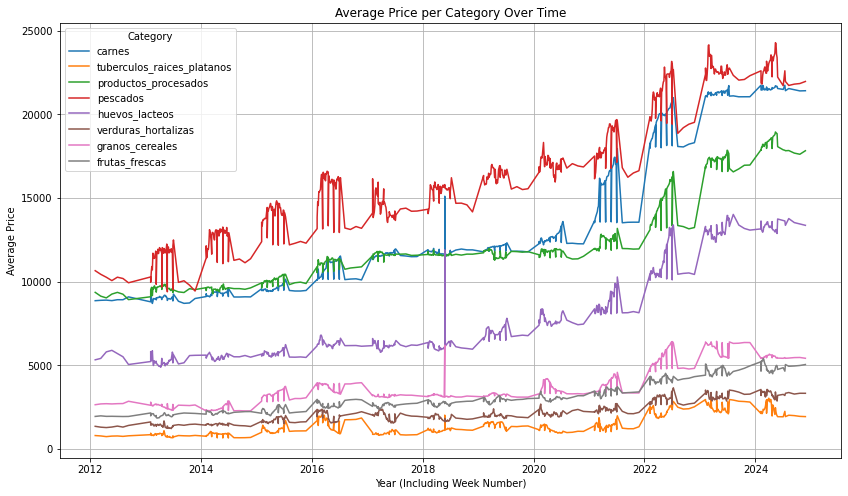

In [157]:
plt.figure(figsize=(14, 8))
# Loop through each category
for category in df['categoria'].unique():
    subset = df[df['categoria'] == category]
    plt.plot(subset['date'], subset['avg'], label=category)

plt.xlabel('Year (Including Week Number)')
plt.ylabel('Average Price')
plt.title('Average Price per Category Over Time')
plt.legend(title="Category")
plt.grid(True)

plt.show()

In [ ]:
df

## testeando

In [156]:
coso = DataWrangler(s3 = s3, 
             bucket_name = bucket_name)

file_name_builder = FileNameBuilder(s3)
first_format_paths_aws = file_name_builder.first_format_paths(bucket_name='sipsa-bucket')
second_format_paths_aws = file_name_builder.second_format_paths(bucket_name='sipsa-bucket')

2024-09-17 04:58:42,509 - INFO - Fetching first format paths from bucket: sipsa-bucket


INFO:__main__:Fetching first format paths from bucket: sipsa-bucket


2024-09-17 04:58:43,482 - INFO - Found 285 files for the first format.


INFO:__main__:Found 285 files for the first format.


2024-09-17 04:58:43,485 - INFO - Fetching second format paths from bucket: sipsa-bucket


INFO:__main__:Fetching second format paths from bucket: sipsa-bucket


2024-09-17 04:58:43,768 - INFO - Found 331 files for the second format.


INFO:__main__:Found 331 files for the second format.


In [185]:
import random 
i = random.randint(0,len(first_format_paths_aws))
file_path = first_format_paths_aws[i]

dataframe = coso.first_format_data_extraction(file_path)
# dataframe = coso.first_format_data_transformation(dataframe,file_path)

dataframe = process_dataframe(dataframe = dataframe, file_path = file_path)

# testing = DataIngestor(engine = engine)
# testing.insert_dataframe_to_db(dataframe = dataframe, 
#                                table_name = table_name)

In [186]:
dataframe

,ciudad,precio_minimo,precio_maximo,precio_medio,tendencia
0,productos y mercados,Precio mínimo,Precio máximo,Precio medio,Tendencia
1,acelga,NaN,NaN,NaN,NaN
2,"armenia, mercar",1067,1067,1067,-
3,"barranquilla, barranquillita",2900,3200,3033,-
4,"bogota, corabastos",400,1000,567,++
...,...,...,...,...,...
5045,"cúcuta, la nueva sexta",1500,1667,1556,=
5046,pamplona (norte de santander),1583,1583,1583,=
5047,santa marta (magdalena),1167,1200,1175,=
5048,"sincelejo, nuevo mercado",2167,2375,2254,=


In [184]:
def process_dataframe(dataframe: pd.DataFrame, 
                      file_path:str) -> pd.DataFrame:
    # Keep only the first five columns and rename them
    dataframe = dataframe.iloc[:, 0:5]
    dataframe.columns = ['ciudad', 'precio_minimo', 'precio_maximo', 'precio_medio', 'tendencia']
    dataframe['ciudad'] = dataframe['ciudad'].str.lower().str.replace('bogotá, d.c.', 'bogota')

    # Remove rows where 'ciudad' is null
    dataframe = dataframe[~dataframe['ciudad'].isnull()]

    # This formatting would have eight food categories within the same spreadsheet divided only by a big title.
    # Such title would include the word 'cuadro'. So, to separate categories, we look for blocks of data contained
    # within two consecutive appearances of such words.

    # Get row indexes where the word 'cuadro' is present
    index_cuadro = dataframe[dataframe['ciudad'].str.contains('cuadro')].index
        
    # Creating target dataframe for all data
    df_final = pd.DataFrame()

#     # Iterating over food categories.
#     for i_categoria in range(len(index_cuadro) + 1):
#         # week 16 of 2015 does not have the 'cuadro' titles. 
#         try:
#             # Capturing first category
#             if i_categoria == 0:
#                 dataframe_categoria = dataframe[1:index_cuadro[i_categoria]]
#             # capturing intermediate categories
#             elif (i_categoria <= 6) and (i_categoria > 0):
#                 dataframe_categoria = dataframe[index_cuadro[i_categoria - 1] + 2:index_cuadro[i_categoria]]
#             # Capturing last category
#             else:
#                 dataframe_categoria = dataframe[index_cuadro[i_categoria - 1] + 2:]

#             # Within each category block, add category name
#             dataframe_categoria['categoria'] = self.categories_dict[i_categoria + 1]

#             # within each category block, there are several products. In the whole reporting, products are very likely to
#             # contain several rows (same food item in different locations). What identifies such product blocks is the
#             # fact that the precio_minimo column will be blank. So the product data would be contain within two
#             # consecutive occurrences of blank prices.
#             index_producto = dataframe_categoria[dataframe_categoria['precio_minimo'].isnull()].index

#             # creating target data frame for product category
#             df_categoria_final = pd.DataFrame()

#             # Iterating over products within food category
#             for i_producto in range(len(index_producto)):

#                 # Capturing the first product in the category
#                 if i_producto == 0:
#                     dataframe_producto = dataframe_categoria.loc[
#                                         index_producto[i_producto] - 1:index_producto[i_producto + 1] - 1].reset_index(
#                         drop=True)

#                 # Capturing all intermediate products
#                 elif i_producto < len(index_producto) - 1:
#                     dataframe_producto = dataframe_categoria.loc[
#                                         index_producto[i_producto]:index_producto[i_producto + 1] - 1].reset_index(
#                             drop=True)

#                 # Capturing last product within category
#                 else:
#                     dataframe_producto = dataframe_categoria.loc[index_producto[i_producto]:].reset_index(drop=True)

#                 # Adding product name column to each block of products
#                 dataframe_producto['producto'] = dataframe_producto['ciudad'][0]

#                 # Keeping only city name under the ciudad column
#                 dataframe_producto['ciudad'] = dataframe_producto['ciudad'].str.replace(r'\s*\([^)]*\)', '', regex=True)

#                 # The name of the marketplaces is included on some of the city names. So we try to retrieve it
#                 try:
#                     dataframe_producto['mercado'] = dataframe_producto['ciudad'].str.split(',').str[1].str.strip()
#                 except:
#                     dataframe_producto['mercado'] = np.nan

#                 # Getting a clean version of city name
#                 try:
#                     dataframe_producto['ciudad'] = dataframe_producto['ciudad'].str.split(',').str[0].str.strip()
#                 except:
#                     None

#                 # Dropping first row
#                 dataframe_producto = dataframe_producto.drop(0)

#                 # Putting together all data for products within food category
#                 df_categoria_final = pd.concat([df_categoria_final, dataframe_producto], ignore_index=True)

#             # Putting together all data
#             df_final = pd.concat([df_final, df_categoria_final], ignore_index=True)
#         except: 
#             None
#     # Once data per file is complete, time stamps are added: year and week number
#     df_final['semana_no'] = int(Path(file_path).name.split('_')[1])  # file_path.stem[5:7]
#     df_final['anho'] = Path(file_path).stem[-4:]

    return dataframe